# Click Through Rate (CTR) Analysis - 2013 Data

## Notes:
Though we intended to use this data based on the year of the stated challenge in Kaggle (2019 and 2020), through our investigation we found that the training data is unchanged year over year, and is actually comprised of labeled data from 2013.

Thus, our original plan to compare model performance over the 2019 and 2020 years and potentially draw inferences from global trends such as the COVID-19 pandemic needed to be reevaluated.

After much thought, the team decided to continue to pursue modeling efforts using the provided 2013 data.

Also note that datasets 'train_sampled.csv' and train_sampled2.csv' should be placed in the 'Data' directory.

## Data Transforms:
- Train/Test Split (80/20) - note, the original kaggle challenge test set does not have ground truth labels so we are utilizing the train set as our full dataset.
- Sampling (due to imbalanced labels)
    - Upsampling
    - Downsampling
    - Random Over Sampling Examples (ROSE)
    - Synthetic Minority Oversampling Technique (SMOTE)

## Modeling:
- Logistic Regression
- Random Forest
- Time Series (Holt Winters and ARIMA)

## Table of Contents

### 1. [Setup and Import](#setup)
### 2. [Sampling Transformations](#sampling)
#### - [Simplistic Upsampling & Downsampling](#updownsampling)
#### - [ROSE](#rose)
#### - [SMOTE](#smote)
### 3. [Modeling](#modeling)
#### [Logistic Regression](#logisticregression)
##### - [glmnet for L1 Regularization (LASSO)](#glmnet)
##### - [Full Dataset](#fullmodel)
##### - [Upsampled](#upmodel)
##### - [Downsampled](#downmodel)
##### - [ROSE](#rosemodel)
##### - [SMOTE](#smotemodel)
#### [EDA](#EDA)
#### [Random Forest](#randomforest)
#### [Time Series](#timeseries)
### 4. [Summary of Results](#resultssummary)

<a class="anchor" id="setup"></a>
## Setup and Import

In [2]:
list.of.packages <- c("dplyr", "caret", "lubridate", "ROSE", "performanceEstimation", "glmnet", "data.table", "forecast", "anytime", "tidyverse", "seasonal", "tseries")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [3]:
library(dplyr)
library(caret)
library(lubridate)
library(ROSE)
library(performanceEstimation)
library(glmnet)
library(data.table)
library(forecast)
library(anytime)
library(tidyverse)
library(seasonal)
library(tseries)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loaded ROSE 0.0-4


Loading required package: Matrix

Loaded glmnet 4.1-4


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:performanceEstimation’:

    CV


── Attaching packages ──────────────────────────────

In [4]:
df <- read.csv('../Data/train_sampled.csv', sep=';')
head(df)

,timestamp,label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,CG1,CG2,CG3,l1,l2,C11,C12
,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,1379278800,0,1895538078,4123103882,2360,33431,88,995,2,177,15,48,"243,377,384,269,46,138,437,279,280,420,161,74,124,3,0,360,17,343,341,435,130,331,60,58,306,77,152,150,151,112,324,99,154,155,76,412,122,139,333,332,335,334,429,430,434,348,432,433,436,285,284,287,286,289,288,291,290,292,267",,,12,0,0,105
2,1379278800,0,3367776458,4116346656,2360,16554,31,995,0,248,15,1387,"50,53,449,106,279,420,161,74,123,364,231,18,239,57,212,278,327,121,120,150,125,126,99,154,155,76,412,122,139,333,332,335,334,199",11782,,20,0,0,105
3,1379278800,0,642099273,1543285064,2458,19317,11,995,2,313,15,821,"273,176,246,249,382,381,47,53,51,385,268,336,422,437,100,270,106,438,27,418,74,124,123,62,376,253,5,357,404,14,431,343,341,435,130,71,408,202,331,59,57,395,78,77,151,99,154,155,76,412,139,333,332,335,334",,,15,0,0,105
4,1379278800,0,352846430,3233566828,2252,16568,88,995,2,177,15,1292,"383,98,220,222,183,184,49,47,53,54,52,56,449,107,279,83,123,208,251,8,360,237,31,17,240,409,57,306,192,276,369,317,99,154,155,76,412,139,333,332,335,334",,,188,0,0,107
5,1379278801,0,3688503904,2541448775,510,1866,10,995,2,419,15,821,"205,204,174,246,247,249,98,96,88,220,224,186,188,183,180,49,47,53,54,52,46,416,422,270,106,279,280,83,161,73,74,124,123,253,5,3,357,19,21,343,341,435,130,39,406,331,59,212,150,99,154,155,76,412,122,139,333,332,335,334,399",,,0,0,0,105
6,1379278802,0,520565064,3388580661,3472,314,75,995,2,262,15,821,"273,174,176,246,247,248,249,250,213,252,377,384,382,381,375,374,93,98,96,220,219,222,184,180,49,53,54,385,422,445,437,100,106,438,80,83,124,123,251,373,3,1,357,14,431,343,341,435,130,132,409,10,72,59,192,114,78,77,75,277,276,275,99,154,155,76,412,326,139,333,332,335,334,347,344,267",,,0,0,0,104


In [5]:
# adding hour of day as a feature
df$hour <- as.numeric(format(as.POSIXct(df$timestamp, origin="1970-01-01", tz="UTC"), format="%H"))

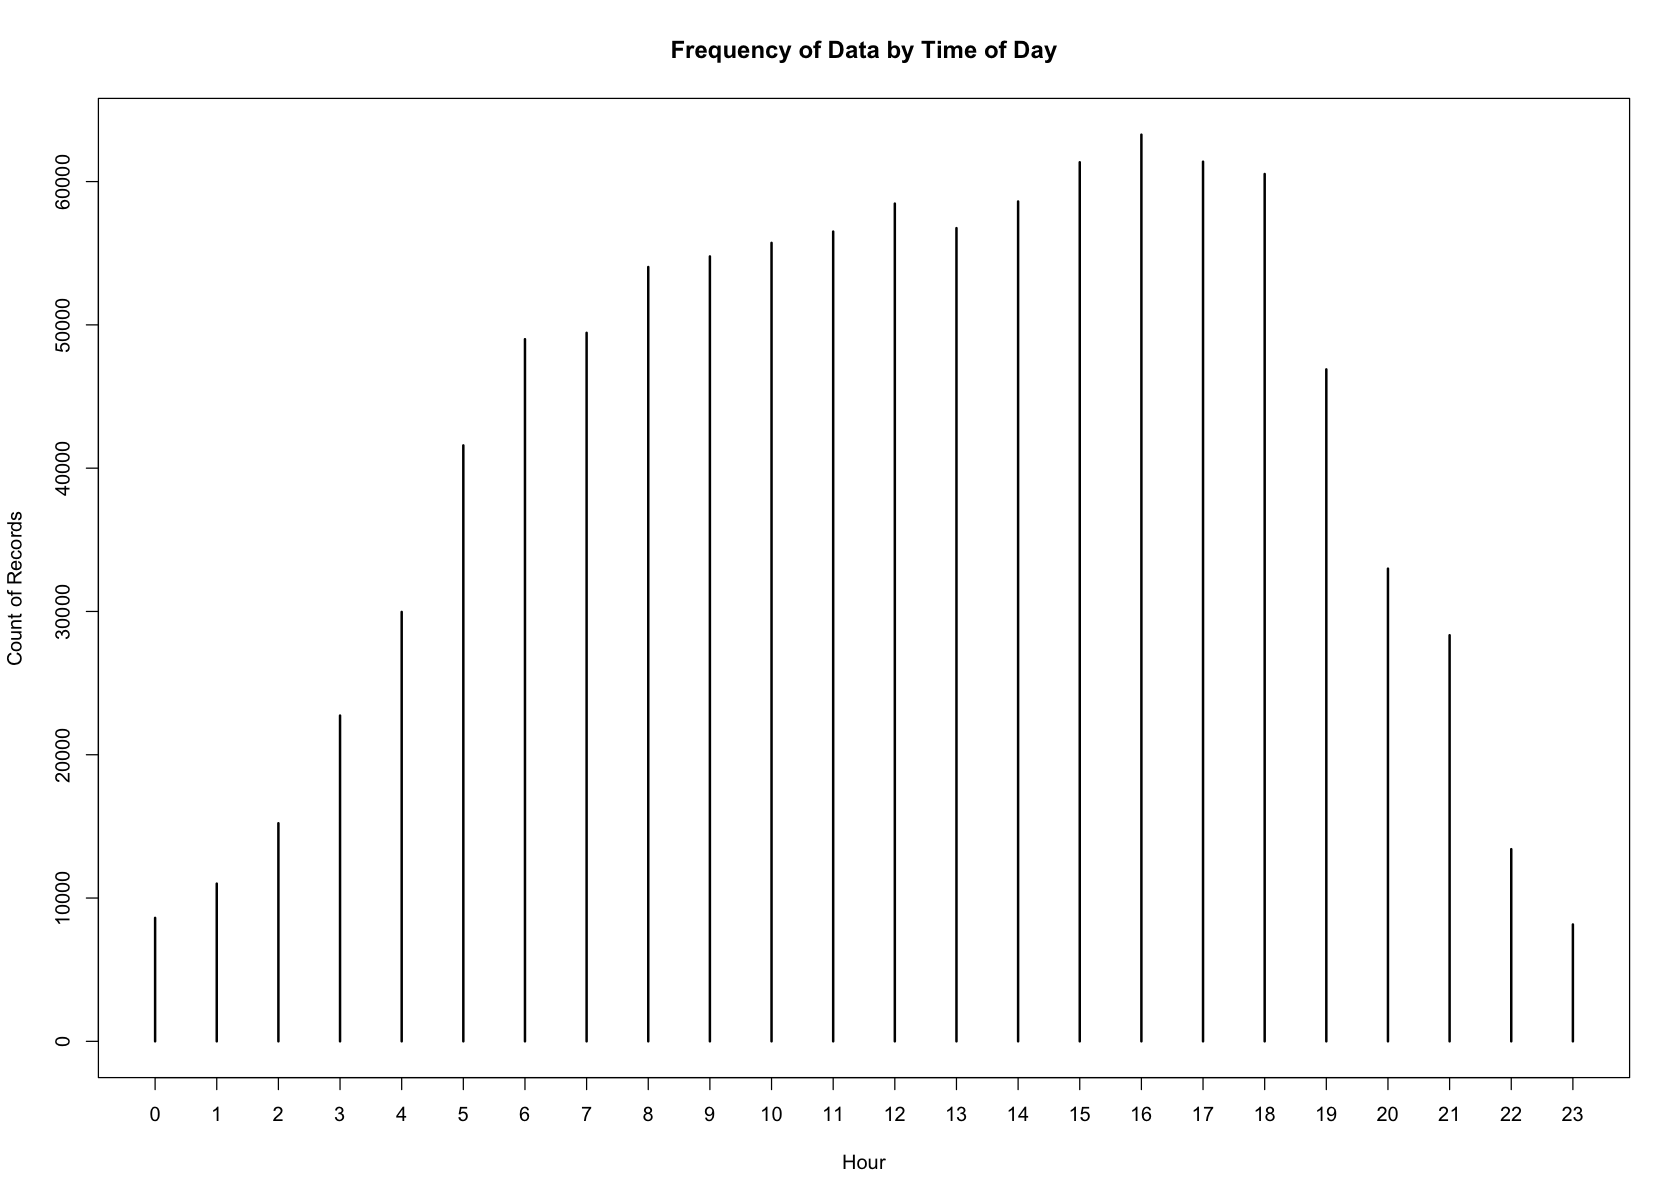

In [6]:
plot(table(df$hour), main="Frequency of Data by Time of Day", xlab="Hour", ylab="Count of Records")

In [7]:
df <- select(df, -contains("CG")) #removing categorical groupings for now
#convert categorical features to factor type

cols <- c("label", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12")
df[cols] <- lapply(df[cols], factor)
df <- df[-1]
head(df)

,label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,l1,l2,C11,C12,hour
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<dbl>
1,0,1895538078,4123103882,2360,33431,88,995,2,177,15,48,12,0,0,105,21
2,0,3367776458,4116346656,2360,16554,31,995,0,248,15,1387,20,0,0,105,21
3,0,642099273,1543285064,2458,19317,11,995,2,313,15,821,15,0,0,105,21
4,0,352846430,3233566828,2252,16568,88,995,2,177,15,1292,188,0,0,107,21
5,0,3688503904,2541448775,510,1866,10,995,2,419,15,821,0,0,0,105,21
6,0,520565064,3388580661,3472,314,75,995,2,262,15,821,0,0,0,104,21


In [8]:
table(df$label) #count of each case of label


     0      1 
996229   2558 

<a class="anchor" id="sampling"></a>

## Sampling Implementations

- upsample
- downsample
- ROSE (TBD)
- SMOTE (TBD)

label classes are imbalanced

Not exactly sure the categorial grouping columns are ('CG'). 

#### We need to examine categorical features to reduce levels, otherwise the model is going to be untenable

In [9]:
rapply(df, function(x) length(unique(x))) #unique counts of values for each variable

label     C1     C2     C3     C4     C5     C6     C7     C8     C9    C10 
     2 327521  50041   5217  22784     92   2772      3    313     83    754 
    l1     l2    C11    C12   hour 
  7684     42      2      8     24

### Convert Sparse Categorical Variables to Numeric (by Frequency)

In [10]:
# convert sparse categoricals to numeric... starting with frequency

df_nums <- setDT(df)
df_nums[ , C1_num := .N , by = .(C1)]
df_nums[ , C2_num := .N , by = .(C2)]
df_nums[ , C3_num := .N , by = .(C3)]
df_nums[ , C4_num := .N , by = .(C4)]
df_nums[ , C5_num := .N , by = .(C5)]
df_nums[ , C6_num := .N , by = .(C6)]
df_nums[ , C8_num := .N , by = .(C8)]
df_nums[ , C9_num := .N , by = .(C9)]
df_nums[ , C10_num := .N , by = .(C10)]

df_nums <- subset(df_nums, select = -c(C1, C2, C3, C4, C5, C6, C8, C9, C10))

head(df_nums)

label,C7,l1,l2,C11,C12,hour,C1_num,C2_num,C3_num,C4_num,C5_num,C6_num,C8_num,C9_num,C10_num
<fct>,<fct>,<int>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,2,12,0,0,105,21,3,835,13128,3383,116966,844720,116966,837465,17020
0,0,20,0,0,105,21,20,960,13128,960,34661,844720,9504,837465,13875
0,2,15,0,0,105,21,16,1546,1673,1546,51393,844720,24725,837465,156786
0,2,188,0,0,107,21,8,1454,79333,5165,116966,844720,116966,837465,2719
0,2,0,0,0,105,21,1,119,136,119,92060,844720,59913,837465,156786
0,2,0,0,0,104,21,2,20,1044,86,1105,844720,8220,837465,156786


In [11]:
rapply(df_nums, function(x) length(unique(x))) #unique counts of values for each variable after converting to numeric

label      C7      l1      l2     C11     C12    hour  C1_num  C2_num  C3_num 
      2       3    7684      42       2       8      24     191     626     743 
 C4_num  C5_num  C6_num  C8_num  C9_num C10_num 
    667      87     292     173      71     234

### 80/20 Train and Test Split

In [12]:
#80/20 training test split

set.seed(1234)

ix <- createDataPartition(df_nums$label, p=.8, list=FALSE)
print('Train Set (80%)')
df_train <- df_nums[ix,]
table(df_train$label)

print('Test Set (20%)')
df_test <- df_nums[-ix,]
table(df_test$label)

[1] "Train Set (80%)"



     0      1 
796984   2047 

[1] "Test Set (20%)"



     0      1 
199245    511 

<a class="anchor" id='updownsampling'></a>

### Upsampling & Downsampling

In [13]:
# upsampling
print("upsampling")
df_train_up <- upSample(x = df_train[,-1], 
                        y = df_train$label) %>%
                            rename(label = Class)

table(df_train_up$label)

df_test_up <- upSample(x = df_test[,-1], 
                        y = df_test$label) %>%
                            rename(label = Class)

table(df_test_up$label)

# downsampling
print("downsampling")
df_train_down <- downSample(x = df_train[,-1],
                          y = df_train$label) %>%
                            rename(label = Class)
table(df_train_down$label)

df_test_down <- downSample(x = df_test[,-1],
                          y = df_test$label) %>%
                            rename(label = Class)
table(df_test_down$label)

[1] "upsampling"



     0      1 
796984 796984 


     0      1 
199245 199245 

[1] "downsampling"



   0    1 
2047 2047 


  0   1 
511 511 

<a class="anchor" id="rose"></a>

### Random Over Sampling Examples (ROSE) Sampling Technique
Note: appears to run very very slow on this dataset. I've tried running this in multiple configurations but am not able to get any results.

ROSE and SMOTE seems really slow.. need to refine this approach

print("random over sampling examples (ROSE)")
df_train_rose <- ROSE(label~., data = df_train)$data %>%
                            rename(label = Class)
table(df_train_rose$label)

<a class="anchor" id="smote"></a>

### Synthetic Minority Oversampling Technique (SMOTE) 

print("synthetic minority oversampling technique (SMOTE)")
df_train_smote <- smote(label~., data = df_train)
table(df_train_smote$Class)

<a class="anchor" id="modeling"></a>

## Modeling Experiments

<a class="anchor" id="logisticregression"></a>

### Logistic Regression

#### glmnet for regularization

given the number of categorical variables

<a class="anchor" id="glmnet"></a>

In [14]:
dft <- model.matrix(label~., data=df_train_down)[,-1]
dfte <- model.matrix(label~., data=df_test_down)[,-1]
y <- as.matrix(df_train_down[16])
ytest <- as.matrix(df_test_down[16])

In [15]:
dftrain_m <- model.matrix(label~., data=df_train)[,-1]
dftest_m <- model.matrix(label~., data=df_test)[,-1]

In [16]:
fit <- glmnet(x = dft, y = y, , family='binomial', alpha=1)

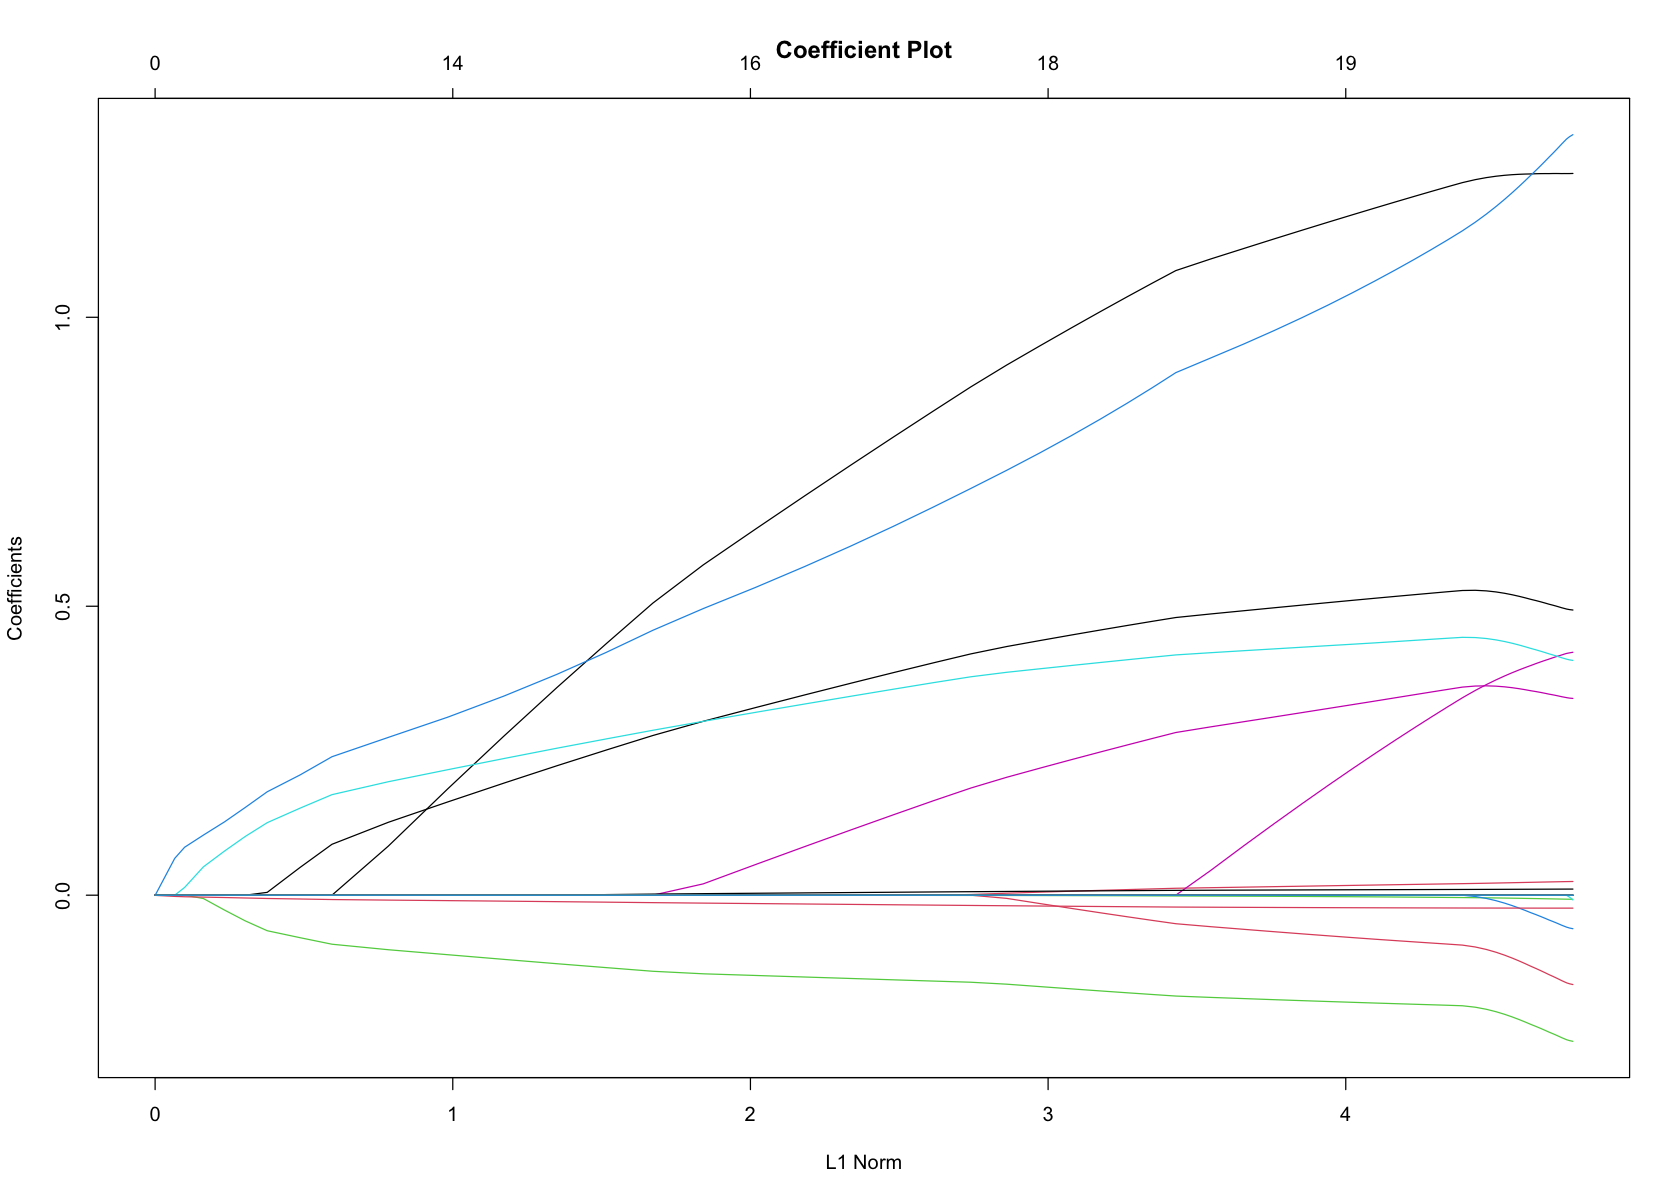

In [17]:
options(repr.plot.width = 14, repr.plot.height = 10)
par(bg="white")

# png(filename="logreg_coeff_plot.png", width=800, height=600)

plot(fit, main="Coefficient Plot")

# dev.off()

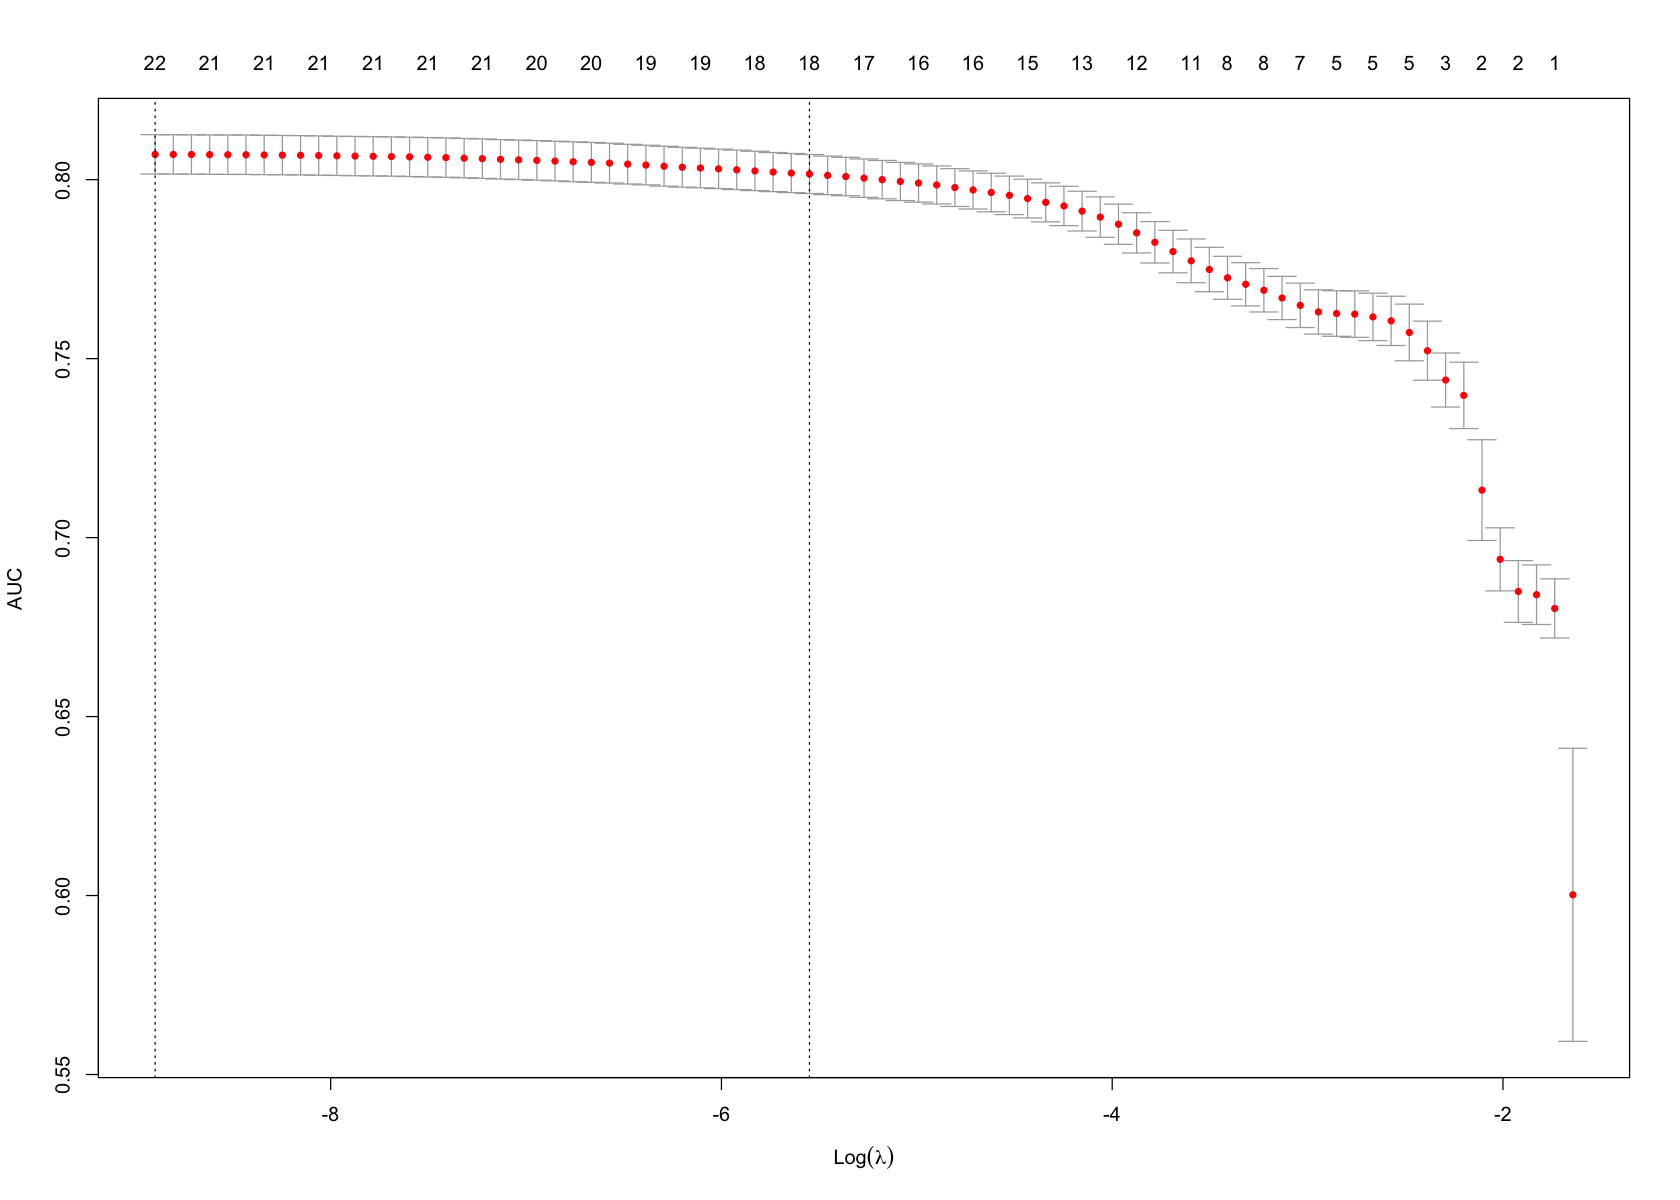

In [18]:
options(repr.plot.width = 14, repr.plot.height = 10)
par(bg="white")

# png(filename="logreg_auc_plot.png", width=800, height=600)

cvfit <- cv.glmnet(x=dft, y=y, family='binomial', alpha=1, nfolds=5, type.measure='auc')
plot(cvfit)

# dev.off()

In [18]:
cvfit$lambda.min

[1] 0.0001365689

In [19]:
cutoff = 0.5

preds <- predict(cvfit, dftrain_m, type='response', s="lambda.min")
preds <- as.integer(preds >= cutoff)

cf = confusionMatrix(as.factor(preds), as.factor(df_train$label), positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 583652    475
         1 213332   1572
                                          
               Accuracy : 0.7324          
                 95% CI : (0.7314, 0.7334)
    No Information Rate : 0.9974          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0095          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.767953        
            Specificity : 0.732326        
         Pos Pred Value : 0.007315        
         Neg Pred Value : 0.999187        
             Prevalence : 0.002562        
         Detection Rate : 0.001967        
   Detection Prevalence : 0.268956        
      Balanced Accuracy : 0.750139        
                                          
       'Positive' Class : 1               
            

In [20]:
cutoff = 0.5

preds <- predict(cvfit, dftest_m, type='response', s="lambda.min")
preds <- as.integer(preds >= cutoff)

cf = confusionMatrix(as.factor(preds), as.factor(df_test$label), positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 145950    128
         1  53295    383
                                          
               Accuracy : 0.7326          
                 95% CI : (0.7306, 0.7345)
    No Information Rate : 0.9974          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0091          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.749511        
            Specificity : 0.732515        
         Pos Pred Value : 0.007135        
         Neg Pred Value : 0.999124        
             Prevalence : 0.002558        
         Detection Rate : 0.001917        
   Detection Prevalence : 0.268718        
      Balanced Accuracy : 0.741013        
                                          
       'Positive' Class : 1               
            

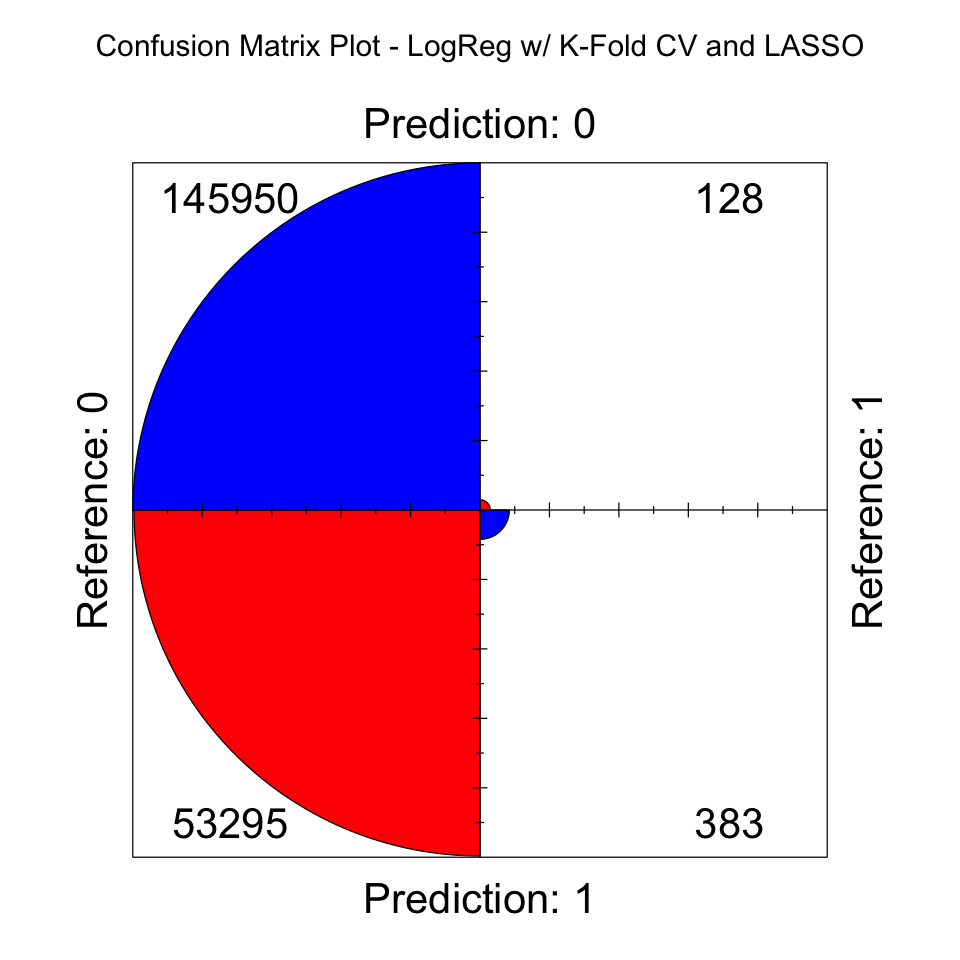

In [21]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(bg="white")

# png(filename="logreg_cm_plot.png", width=600, height=600)

fourfoldplot(cf$table, color = c("red", "blue"), conf.level = 0, margin = 1, main = "Confusion Matrix Plot - LogReg w/ K-Fold CV and LASSO")

# dev.off()

In [22]:
coef(cvfit, s=cvfit$lambda.min) #coefficients for the best lambda in this case

23 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept)  1.546726e+00
C71          1.248881e+00
C72          2.370117e-02
l1          -7.048732e-03
l2           1.315999e+00
C111        -8.179482e-03
C12101       4.203603e-01
C12102       4.934738e-01
C12103      -1.546012e-01
C12104      -2.528785e-01
C12105      -5.800815e-02
C12106       4.062737e-01
C12107       3.404800e-01
hour         1.057411e-02
C1_num      -2.239819e-02
C2_num      -2.245923e-05
C3_num      -1.755246e-05
C4_num      -1.196777e-04
C5_num      -6.053836e-06
C6_num      -1.080767e-06
C8_num      -3.254400e-06
C9_num      -3.548967e-07
C10_num     -2.393766e-06

<a class="anchor" id="fullmodel"></a>

#### logistic regression on original dataset (no sampling)

In [23]:
ctr_model_2019_full <- glm(formula = label ~ ., 
                      family='binomial', 
                      data=df_train)

summary(ctr_model_2019_full)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = label ~ ., family = "binomial", data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7334  -0.0791  -0.0531  -0.0336   5.7175  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.929e+01  3.517e+00   5.484 4.15e-08 ***
C71          2.774e-01  3.056e-01   0.908 0.363998    
C72         -1.878e-02  4.600e-02  -0.408 0.683082    
l1          -5.324e-03  1.250e-03  -4.259 2.06e-05 ***
l2           1.370e-01  1.892e-02   7.243 4.40e-13 ***
C111        -2.335e+01  3.493e+00  -6.685 2.31e-11 ***
C12101       3.486e-01  1.016e+00   0.343 0.731594    
C12102       1.662e-01  1.868e-01   0.890 0.373536    
C12103      -3.478e-01  1.752e-01  -1.985 0.047149 *  
C12104      -4.084e-01  1.675e-01  -2.438 0.014767 *  
C12105      -2.903e-01  1.693e-01  -1.715 0.086377 .  
C12106       2.268e-01  1.683e-01   1.348 0.177728    
C12107      -3.730e-04  2.111e-01  -0.002 0.998590    
hour         5.688e-03  4.030e-

<b> keeping statistically significant variables: (.05 threshold) </b>
- l1
- l2
- C11
- C1_num
- C3_num
- C4_num
- C5_num
- C6_num
- C8_num
- C10_num

In [24]:
## placeholder for rerunning model with the above variables removed
ctr_model_2019_full <- glm(formula = label ~ l1+l2+C11+C1_num+C3_num+C4_num+C5_num+C6_num+C8_num+C10_num, 
                      family='binomial', 
                      data=df_train)

summary(ctr_model_2019_full)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = label ~ l1 + l2 + C11 + C1_num + C3_num + C4_num + 
    C5_num + C6_num + C8_num + C10_num, family = "binomial", 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7645  -0.0794  -0.0539  -0.0348   5.6986  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.910e+01  3.449e+00   5.538 3.06e-08 ***
l1          -5.228e-03  1.241e-03  -4.213 2.52e-05 ***
l2           1.405e-01  1.911e-02   7.353 1.94e-13 ***
C111        -2.331e+01  3.435e+00  -6.786 1.15e-11 ***
C1_num      -3.032e-02  3.733e-03  -8.122 4.57e-16 ***
C3_num      -1.781e-05  4.138e-06  -4.304 1.68e-05 ***
C4_num      -1.571e-04  3.225e-05  -4.872 1.10e-06 ***
C5_num      -5.907e-06  4.635e-07 -12.745  < 2e-16 ***
C6_num      -2.868e-05  4.080e-06  -7.030 2.07e-12 ***
C8_num      -4.169e-06  1.000e-06  -4.169 3.06e-05 ***
C10_num     -1.978e-06  4.242e-07  -4.662 3.14e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.

In [25]:
preds <- predict(ctr_model_2019_full, df_train, type='response')

cutoff = 0.5
preds <- as.integer(preds >= cutoff)

cf = confusionMatrix(as.factor(preds), df_train$label, positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 796980   2047
         1      4      0
                                          
               Accuracy : 0.9974          
                 95% CI : (0.9973, 0.9975)
    No Information Rate : 0.9974          
    P-Value [Acc > NIR] : 0.5411          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.000e+00       
            Specificity : 1.000e+00       
         Pos Pred Value : 0.000e+00       
         Neg Pred Value : 9.974e-01       
             Prevalence : 2.562e-03       
         Detection Rate : 0.000e+00       
   Detection Prevalence : 5.006e-06       
      Balanced Accuracy : 5.000e-01       
                                          
       'Positive' Class : 1               
            

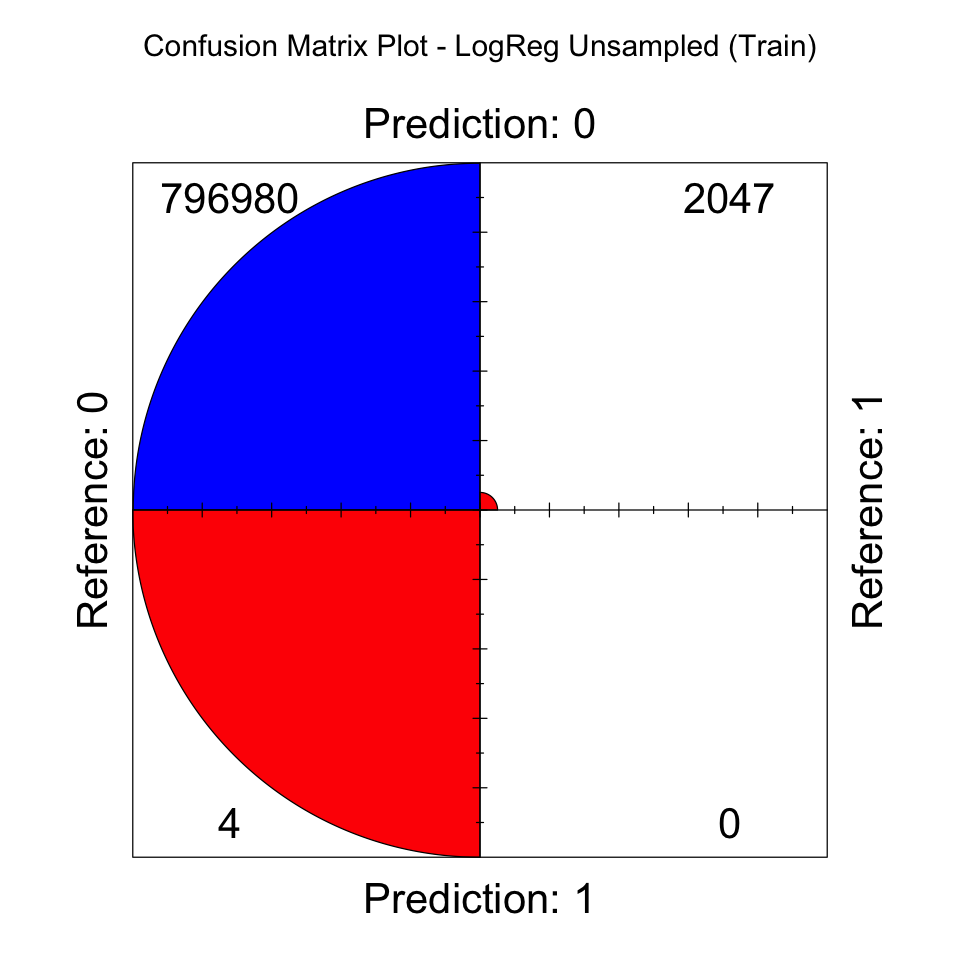

In [26]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(bg="white")

fourfoldplot(cf$table, color = c("red", "blue"), conf.level = 0, margin = 1, main = "Confusion Matrix Plot - LogReg Unsampled (Train)")

In [27]:
preds <- predict(ctr_model_2019_full, df_test, type='response')

cutoff = 0.5
preds <- as.integer(preds >= cutoff)

cf = confusionMatrix(as.factor(preds), df_test$label, positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 199244    511
         1      1      0
                                          
               Accuracy : 0.9974          
                 95% CI : (0.9972, 0.9977)
    No Information Rate : 0.9974          
    P-Value [Acc > NIR] : 0.5294          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.000e+00       
            Specificity : 1.000e+00       
         Pos Pred Value : 0.000e+00       
         Neg Pred Value : 9.974e-01       
             Prevalence : 2.558e-03       
         Detection Rate : 0.000e+00       
   Detection Prevalence : 5.006e-06       
      Balanced Accuracy : 5.000e-01       
                                          
       'Positive' Class : 1               
            

Accuracy: 92.5 
However, specificity (FNR) is extremely low.

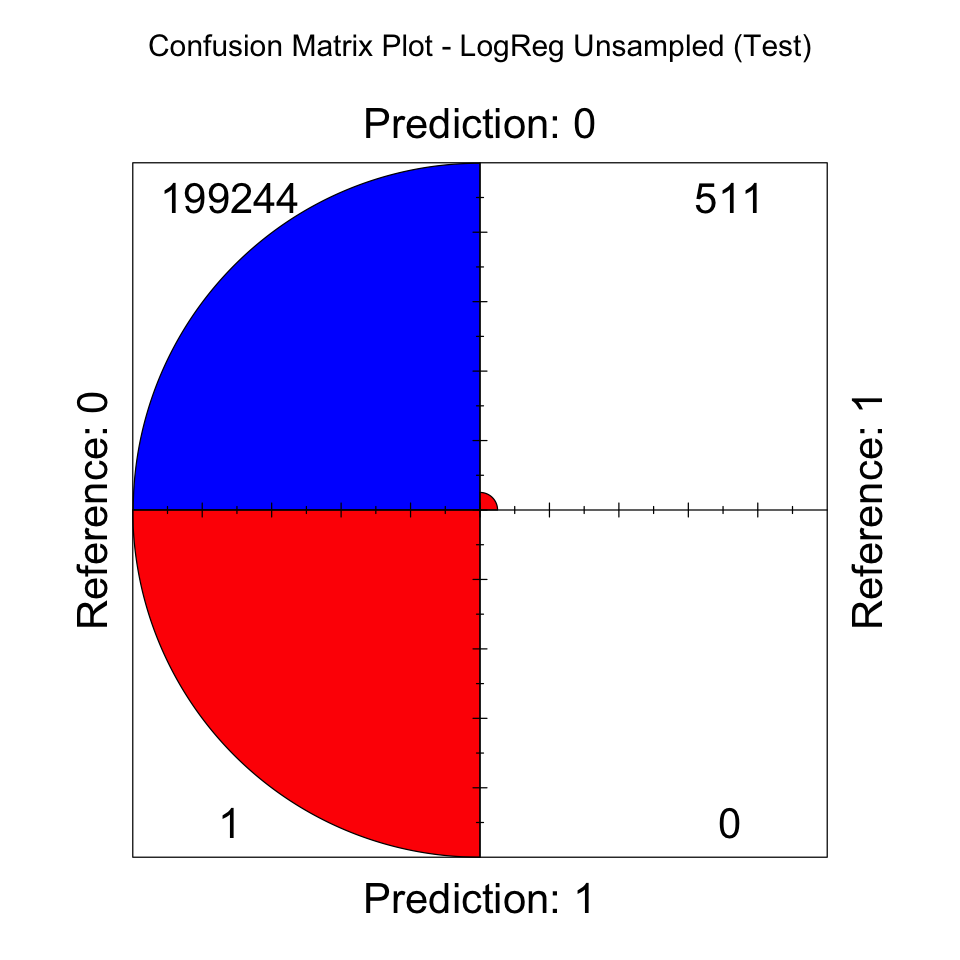

In [28]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(bg="white")

fourfoldplot(cf$table, color = c("red", "blue"), conf.level = 0, margin = 1, main = "Confusion Matrix Plot - LogReg Unsampled (Test)")

<a class="anchor" id="upmodel"></a>

#### Upsampled Model

In [29]:
ctr_model_2019_up <- glm(formula = label ~ ., 
                      family='binomial', 
                      data=df_train_up)
summary(ctr_model_2019_up)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = label ~ ., family = "binomial", data = df_train_up)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.8915   0.0000   0.8553   3.7929  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  2.334e+01  3.157e-01   73.930  < 2e-16 ***
C71          8.122e-01  3.272e-02   24.825  < 2e-16 ***
C72         -4.688e-02  3.892e-03  -12.044  < 2e-16 ***
l1          -8.818e-03  9.000e-05  -97.971  < 2e-16 ***
l2           1.544e+00  9.019e-03  171.197  < 2e-16 ***
C111        -2.142e+01  3.120e-01  -68.656  < 2e-16 ***
C12101       6.063e-01  8.611e-02    7.042  1.9e-12 ***
C12102       2.153e-01  2.008e-02   10.722  < 2e-16 ***
C12103      -4.075e-01  1.837e-02  -22.177  < 2e-16 ***
C12104      -4.659e-01  1.780e-02  -26.181  < 2e-16 ***
C12105      -3.688e-01  1.793e-02  -20.565  < 2e-16 ***
C12106       1.835e-01  1.792e-02   10.240  < 2e-16 ***
C12107       2.484e-02  2.112e-02    1.176     0.24    
hour         8

all variables here appear to be statistically significant

In [30]:
preds <- predict(ctr_model_2019_up, df_train, type='response')

cutoff = 0.5
preds <- as.integer(preds >= cutoff)

cf = confusionMatrix(as.factor(preds), df_train$label, positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 580952    477
         1 216032   1570
                                        
               Accuracy : 0.729         
                 95% CI : (0.7281, 0.73)
    No Information Rate : 0.9974        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.0093        
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.766976      
            Specificity : 0.728938      
         Pos Pred Value : 0.007215      
         Neg Pred Value : 0.999180      
             Prevalence : 0.002562      
         Detection Rate : 0.001965      
   Detection Prevalence : 0.272332      
      Balanced Accuracy : 0.747957      
                                        
       'Positive' Class : 1             
                                        

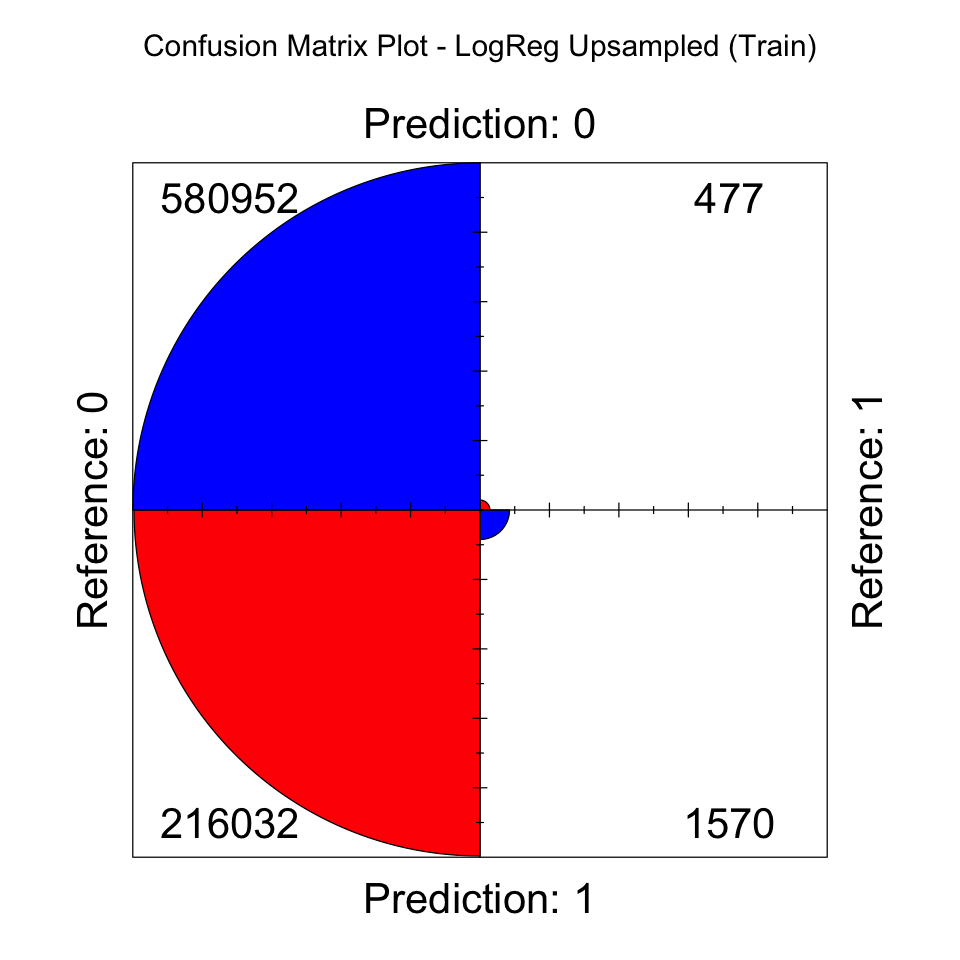

In [31]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(bg="white")

fourfoldplot(cf$table, color = c("red", "blue"), conf.level = 0, margin = 1, main = "Confusion Matrix Plot - LogReg Upsampled (Train)")

In [32]:
preds <- predict(ctr_model_2019_up, df_test, type='response')

cutoff = 0.5
preds <- as.integer(preds >= cutoff)

cf <- confusionMatrix(as.factor(preds), df_test$label, positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 145285    127
         1  53960    384
                                          
               Accuracy : 0.7292          
                 95% CI : (0.7273, 0.7312)
    No Information Rate : 0.9974          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.009           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.751468        
            Specificity : 0.729178        
         Pos Pred Value : 0.007066        
         Neg Pred Value : 0.999127        
             Prevalence : 0.002558        
         Detection Rate : 0.001922        
   Detection Prevalence : 0.272052        
      Balanced Accuracy : 0.740323        
                                          
       'Positive' Class : 1               
            

Overall accuracy decreased to 79.96% however specificity is closer to being balanced. FPR is much higher in this case

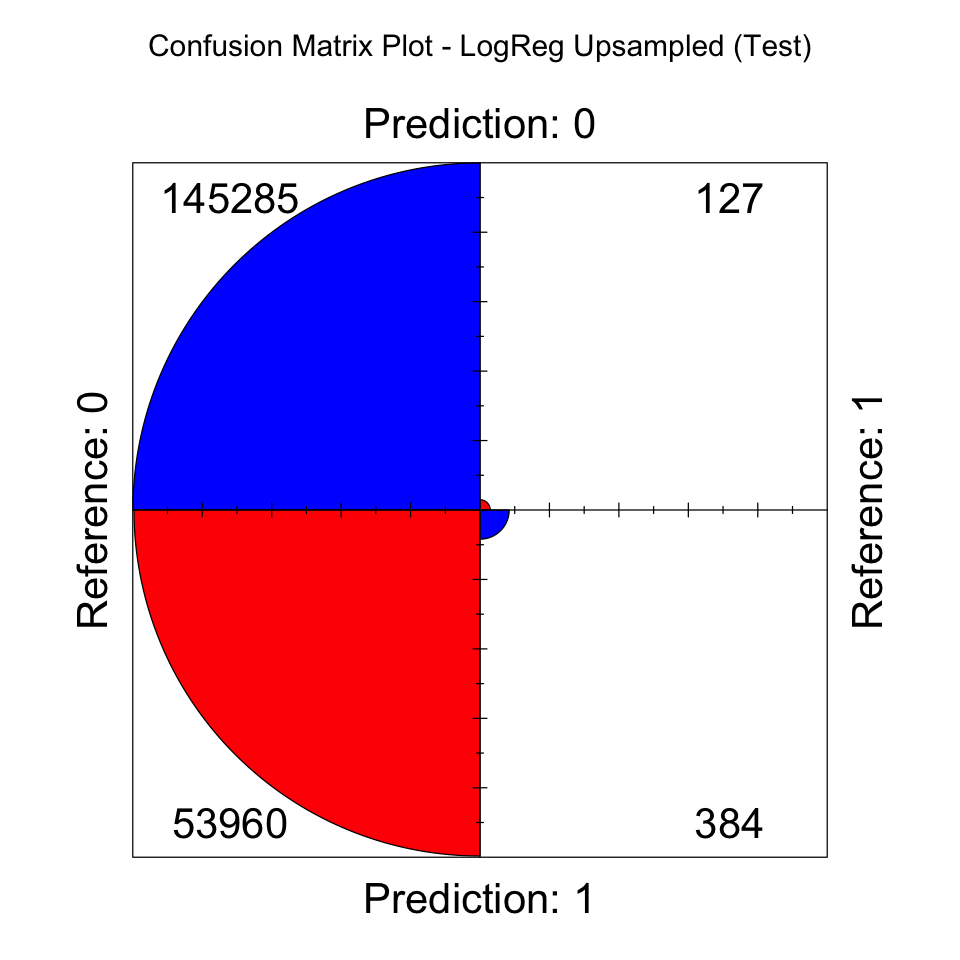

In [33]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(bg="white")

fourfoldplot(cf$table, color = c("red", "blue"), conf.level = 0, margin = 1, main = "Confusion Matrix Plot - LogReg Upsampled (Test)")

#### Downsampled Model

<a class="anchor" id="downmodel"></a>

In [34]:
ctr_model_2019_down <- glm(formula = label ~ ., 
                      family='binomial', 
                      data=df_train_down)
summary(ctr_model_2019_down)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = label ~ ., family = "binomial", data = df_train_down)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.9492  -0.8797   0.0000   0.8567   3.8646  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.774e+01  6.198e+00   4.476 7.62e-06 ***
C71          1.218e+00  6.707e-01   1.817 0.069283 .  
C72          3.193e-02  7.701e-02   0.415 0.678368    
l1          -7.859e-03  1.690e-03  -4.649 3.33e-06 ***
l2           1.348e+00  1.631e-01   8.267  < 2e-16 ***
C111        -2.595e+01  6.126e+00  -4.236 2.28e-05 ***
C12101       2.923e-01  1.456e+00   0.201 0.840910    
C12102       3.682e-01  3.867e-01   0.952 0.341031    
C12103      -2.543e-01  3.507e-01  -0.725 0.468414    
C12104      -3.804e-01  3.382e-01  -1.125 0.260681    
C12105      -2.047e-01  3.415e-01  -0.599 0.548879    
C12106       2.768e-01  3.409e-01   0.812 0.416800    
C12107       2.288e-01  4.031e-01   0.567 0.570417    
hour         1.038e-02  6.

<b> keeping statistically insignificant variables: (.05 threshold) </b>
- l1
- l2
- C11
- C1_num
- C3_num
- C5_num
- C6_num
- C8_num
- C10_num

In [35]:
ctr_model_2019_down <- glm(formula = label ~ l1+l2+C11+C1_num+C3_num+C5_num+C6_num+C8_num+C10_num, 
                      family='binomial', 
                      data=df_train_down)
summary(ctr_model_2019_down)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = label ~ l1 + l2 + C11 + C1_num + C3_num + C5_num + 
    C6_num + C8_num + C10_num, family = "binomial", data = df_train_down)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.9777  -0.9209   0.0000   0.8878   3.9431  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.830e+01  6.000e+00   4.717 2.40e-06 ***
l1          -8.204e-03  1.685e-03  -4.870 1.12e-06 ***
l2           1.385e+00  1.649e-01   8.400  < 2e-16 ***
C111        -2.654e+01  5.965e+00  -4.449 8.61e-06 ***
C1_num      -2.323e-02  3.863e-03  -6.013 1.82e-09 ***
C3_num      -2.589e-05  4.025e-06  -6.433 1.25e-10 ***
C5_num      -5.790e-06  5.710e-07 -10.140  < 2e-16 ***
C6_num      -3.281e-05  7.099e-06  -4.622 3.81e-06 ***
C8_num      -3.932e-06  1.382e-06  -2.845  0.00444 ** 
C10_num     -2.094e-06  6.575e-07  -3.185  0.00145 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to 

In [36]:
preds <- predict(ctr_model_2019_down, df_train, type='response')

cutoff = 0.5
preds <- as.integer(preds >= cutoff)

cf = confusionMatrix(as.factor(preds), df_train$label, positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 576908    456
         1 220076   1591
                                        
               Accuracy : 0.724         
                 95% CI : (0.723, 0.725)
    No Information Rate : 0.9974        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.0092        
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.777235      
            Specificity : 0.723864      
         Pos Pred Value : 0.007177      
         Neg Pred Value : 0.999210      
             Prevalence : 0.002562      
         Detection Rate : 0.001991      
   Detection Prevalence : 0.277420      
      Balanced Accuracy : 0.750549      
                                        
       'Positive' Class : 1             
                                        

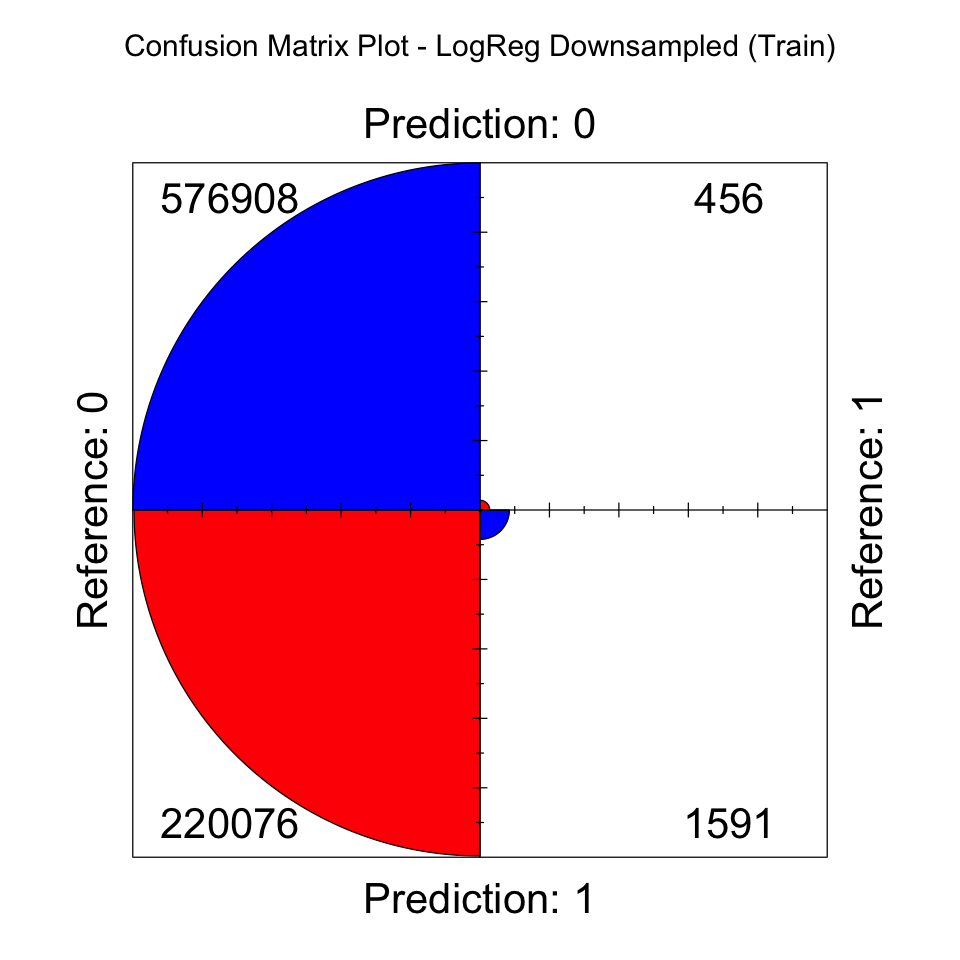

In [37]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(bg="white")

fourfoldplot(cf$table, color = c("red", "blue"), conf.level = 0, margin = 1, main = "Confusion Matrix Plot - LogReg Downsampled (Train)")

In [38]:
preds <- predict(ctr_model_2019_down, df_test, type='response')

cutoff = 0.5
preds <- as.integer(preds >= cutoff)

cf = confusionMatrix(as.factor(preds), df_test$label, positive='1')
cf

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 144136    121
         1  55109    390
                                          
               Accuracy : 0.7235          
                 95% CI : (0.7215, 0.7255)
    No Information Rate : 0.9974          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0089          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.763209        
            Specificity : 0.723411        
         Pos Pred Value : 0.007027        
         Neg Pred Value : 0.999161        
             Prevalence : 0.002558        
         Detection Rate : 0.001952        
   Detection Prevalence : 0.277834        
      Balanced Accuracy : 0.743310        
                                          
       'Positive' Class : 1               
            

These figures are in line with the upsampled set, with an accuracy of 79.91%.

The decrease in overall accuracy and increase in FPR here makes sense as we've tried to increase the models' attention to features of the positive case (1, or a Click Through) 

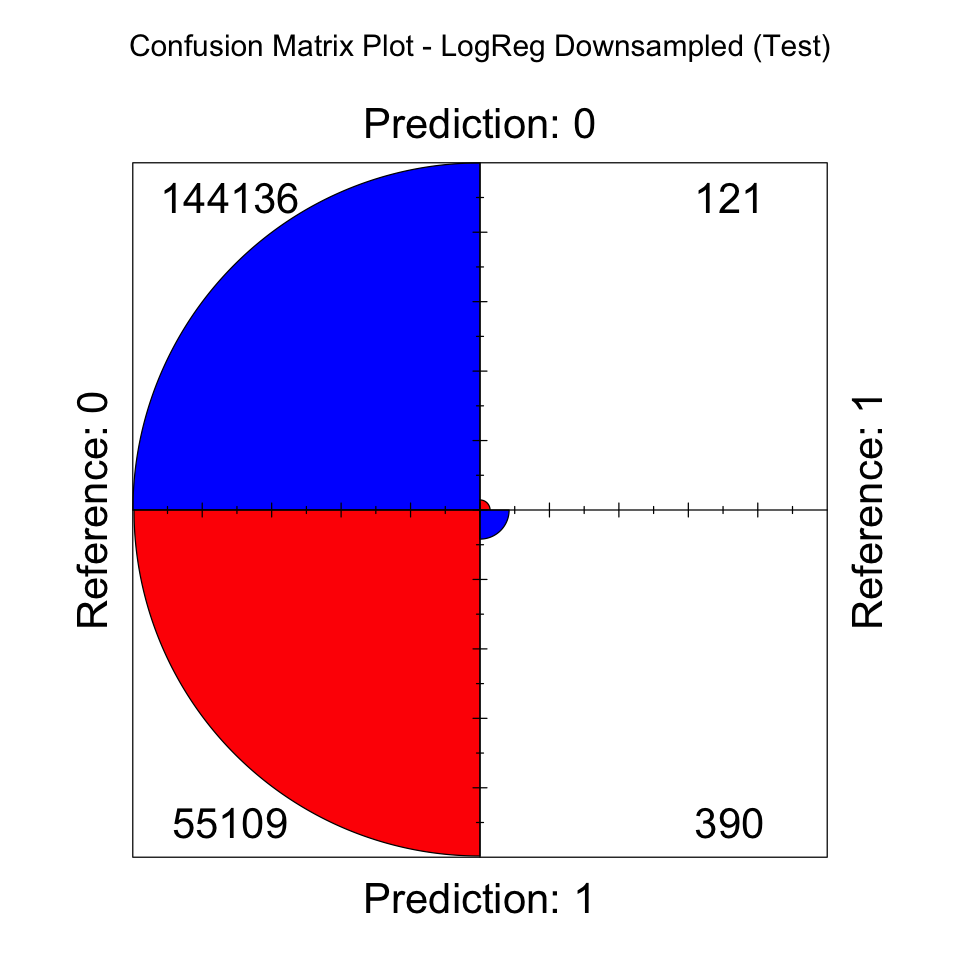

In [39]:
fourfoldplot(cf$table, color = c("red", "blue"), conf.level = 0, margin = 1, main = "Confusion Matrix Plot - LogReg Downsampled (Test)")

### EDA

<a class="anchor" id="EDA"></a>

In [41]:
data=read.table('../Data/train_sampled2.csv',header=T,sep=";")
#View(data)
summary(as.factor(data$label))
catcols=c("C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12")
for(i in c("label",catcols)){
  data[,i]=as.factor(data[,i])
}
data$datetime=anytime(data$timestamp)
summary(data)

0      1 
934112  76302

   timestamp         label               C1                   C2        
 Min.   :1.379e+09   0:934112   4013070138:    997   2277192293: 12035  
 1st Qu.:1.379e+09   1: 76302   4091568405:    670   3009907911:  6359  
 Median :1.379e+09              1480636129:    500   100422603 :  4870  
 Mean   :1.379e+09              2075671839:    398   1285084448:  4851  
 3rd Qu.:1.379e+09              3428596202:    353   1207044385:  4016  
 Max.   :1.380e+09              1422821974:    349   3121392431:  2983  
                                (Other)   :1007147   (Other)   :975300  
       C3               C4               C5               C6         C7        
 2252   : 74487   21050  : 12035   30     :209308   995    :828246   0:434591  
 2081   : 31089   33022  : 10239   88     :111106   3905   : 29493   1:  2654  
 3774   : 15998   923    :  7771   10     : 91391   3403   : 10072   2:573169  
 4454   : 14649   20580  :  6359   11     : 49769   1390   :  3111             
 3550   : 13671 

Box Plots PDF

In [42]:
pdf("graphs.pdf")
numericcols=c("l1","l2")
par(mfrow = c(3,3))
for(i in numericcols){
  boxplot(data[,i],main=i)
  boxplot(data[,i]~data$label,main=i)
}
for(i in catcols){
  freqs=sort(table(data[,i]),decreasing=T)[1:10]
  x=barplot(freqs,main=i,las=2)
  text(x,freqs,label=freqs,pos=1,offset=1.5,srt=90)
  
  freqs=sort(table(data[data$label==0,i]),decreasing=T)[1:10]
  x=barplot(freqs,main=paste(i,"label0"),las=2)
  text(x,freqs,label=freqs,pos=1,offset=1.5,srt=90)
  
  freqs=sort(table(data[data$label==1,i]),decreasing=T)[1:10]
  x=barplot(freqs,main=paste(i,"label0"),las=2)
  text(x,freqs,label=freqs,pos=1,offset=1.5,srt=90)
}
dev.off()

pdf 
  2

Timeseries Graphs

In [43]:
pdf("timedaypart_graphs.pdf")
par(mfrow = c(1,1))
t=table(format(data$datetime,format="%d%H"))
x=barplot(t,main="DayHour traffic breakout",las=2,xlab="DayHour",ylab="Frequency")
text(x,t,label=t,pos=1,offset=1.5,srt=90)

t=table(data$label,format(data$datetime,format="%d%H"))
x=barplot(t,main="DayHour traffic breakout by click",las=2,xlab="DayHour",ylab="Frequency")

t2=rbind(t,colSums(t))
x=barplot(rbind(t2[1,]/t2[3,],t2[2,]/t2[3,]),main="DayHour traffic breakout by click",las=2,xlab="DayHour",ylab="Click Percentage")
#text(x,1,label=t,pos=1,offset=-1.5,srt=90)
dev.off()

pdf 
  2

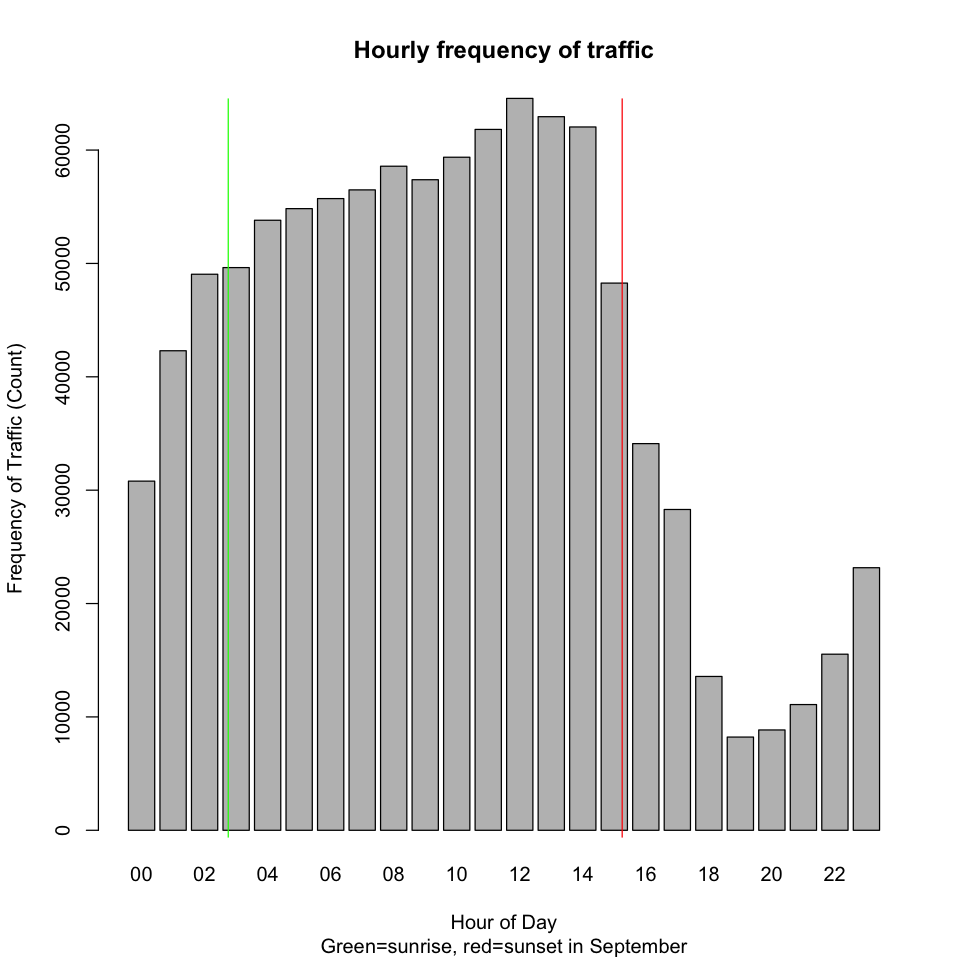

In [44]:
#add hour
data$hour=as.factor(format(data$datetime,'%H'))
barplot(summary(data$hour),main="Hourly frequency of traffic",ylab="Frequency of Traffic (Count)",xlab="Hour of Day",sub="Green=sunrise, red=sunset in September")
abline(v=4,col="green")
abline(v=19,col="red")
data$sunlight=as.factor(as.numeric(as.numeric(data$hour)>=3 & as.numeric(data$hour)<=15))

Correlation numeric variables

In [45]:
#correlation of columns
round(cor(data[,numericcols]),2)

,l1,l2
l1,1.00,0.03
l2,0.03,1.00


### Random Forest

<a class="anchor" id="randomforest"></a>

Load Random Forest

In [46]:
library(randomForest)
cols=c("label",numericcols,catcols,"hour","sunlight")

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:seasonal’:

    outlier


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




Downsample data to get class balance

In [47]:
#downsample data to get class balance
set.seed(123)
data2=data[data$label==1,cols]
data0=data[data$label==0,cols]
sampled=sample(1:nrow(data0),size=nrow(data2))
data2=rbind(data2,data0[sampled,])
summary(data2)

 label           l1                 l2                   C1        
 0:76302   Min.   :    0.00   Min.   : 0.0000   4013070138:    86  
 1:76302   1st Qu.:    0.00   1st Qu.: 0.0000   4091568405:    57  
           Median :    1.00   Median : 0.0000   3018961855:    47  
           Mean   :   60.28   Mean   : 0.1221   3480220152:    47  
           3rd Qu.:    7.00   3rd Qu.: 0.0000   1480636129:    39  
           Max.   :36090.00   Max.   :92.0000   2845203966:    39  
                                                (Other)   :152289  
          C2               C3               C4               C5       
 2879782277:  1542   2252   :  6344   26981  :  1542   30     :22714  
 3775616631:  1215   2081   :  3796   14838  :  1215   1      :15389  
 2277192293:  1088   6216   :  2757   21050  :  1088   83     :14834  
 3126403322:   939   5704   :  2042   25359  :   939   10     :11895  
 1161865110:   894   3774   :  1815   27694  :   929   88     :10836  
 4110536592:   632   4363   : 

RandomForest doesn't like more than 53 categories within predictors

In [48]:
#rf doesn't like when there's more than 53 categories within a predictor
for(i in c(catcols)){
  freqs=as.numeric(names(sort(table(data2[,i]),decreasing=T)[1:min(52,length(unique(data2[,i])))]))
  v=data2[,i]
  vv=sapply(v,function(ii) if(ii %in% freqs) ii else -1)
  data2[,i]=as.factor(vv)
}

Train/test sets

In [49]:
#train/test sets
set.seed(123)
sampled <- sample(1:nrow(data2),size=.7*nrow(data2))
trainset=data2[sampled,]
testset=data2[-sampled,]

Build Random Forest Model

In [50]:
#mtry=4, ntree=500 by default
model=randomForest(label~.,trainset)

Evaluation Function

In [51]:
#function to evaluate model on dataset
evalmetrics<-function(modelm,sampleset){
  samplepredicts=predict(modelm,sampleset,type="response")
  cm=matrix(table(as.factor(sampleset$label),samplepredicts),nrow=2,ncol=2)
  accuracy=(cm[1,1]+cm[2,2])/sum(cm)
  sensitivity=cm[2,2]/sum(cm[2,])
  specificty=cm[1,1]/sum(cm[1,])
  colnames(cm)=c(0,1)
  rownames(cm)=c(0,1)
  #cm
  return(c(accuracy,sensitivity,specificty))
}

Evaluation Metrics and Variable Importance Plot

[1] 0.9608882 0.9493564 0.9724719

[1] 0.8015377 0.8740503 0.7297814

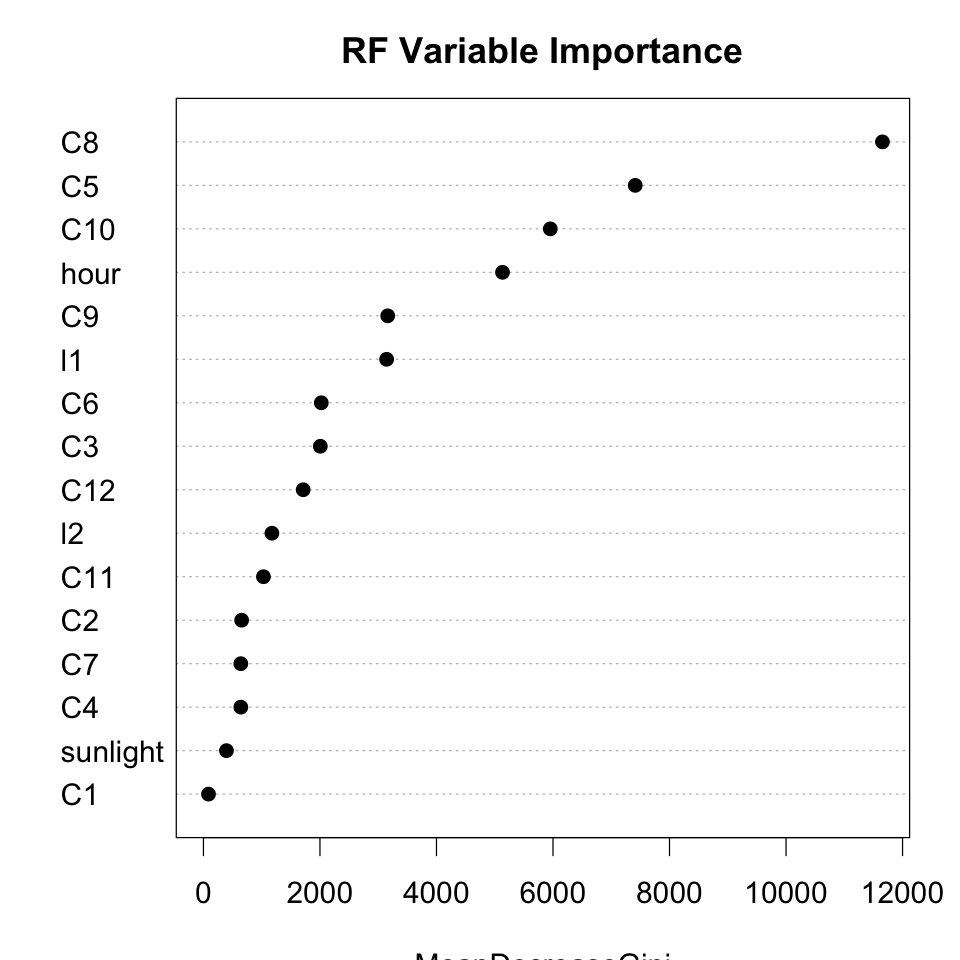

In [52]:
evalmetrics(model,trainset)
evalmetrics(model,testset)
#variable importance
varImpPlot(model,color="black",pch=19,cex=1.5,main="RF Variable Importance")


HyperParameter Testing

In [53]:
#hyperparameter tuning
hyperoutputdf=data.frame(mtry=numeric(),ntree=numeric(),trainaccuracy=numeric(),trainsensitivity=numeric(),trainspecificity=numeric(),testaccuracy=numeric(),testsensitivity=numeric(),testspecificity=numeric())
i=1
for(mtry in 3:6){
  for(ntree in c(250,500,750)){
    set.seed(123)
    model=randomForest(label~.,trainset,mtry=mtry,ntree=ntree)
    trainevals=evalmetrics(model,trainset)
    testevals=evalmetrics(model,testset)
    hyperoutputdf[i,]=c(mtry,ntree,trainevals[1],trainevals[2],trainevals[3],testevals[1],testevals[2],testevals[3])
    i=i+1
  }
}
hyperoutputdf

,mtry,ntree,trainaccuracy,trainsensitivity,trainspecificity,testaccuracy,testsensitivity,testspecificity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,250,0.9184438,0.9089873,0.9279428,0.8056878,0.8710202,0.7410369
2,3,500,0.9190616,0.9090620,0.9291062,0.8055786,0.8714593,0.7403850
3,3,750,0.9195765,0.9090994,0.9301008,0.8057097,0.8718106,0.7402981
4,4,250,0.9601393,0.9493564,0.9709707,0.8012975,0.8734355,0.7299118
5,4,500,0.9608414,0.9498795,0.9718527,0.8015377,0.8729964,0.7308244
6,4,750,0.9610848,0.9499542,0.9722655,0.8015814,0.8731720,0.7307375
7,5,250,0.9770834,0.9703349,0.9838622,0.7983487,0.8731720,0.7243058
8,5,500,0.9776076,0.9709701,0.9842750,0.7987855,0.8730842,0.7252618
9,5,750,0.9778042,0.9714558,0.9841812,0.7985890,0.8736112,0.7243492


Best Model from Hyperparameter tuning

[1] 0.9195765 0.9090994 0.9301008

[1] 0.8057097 0.8718106 0.7402981

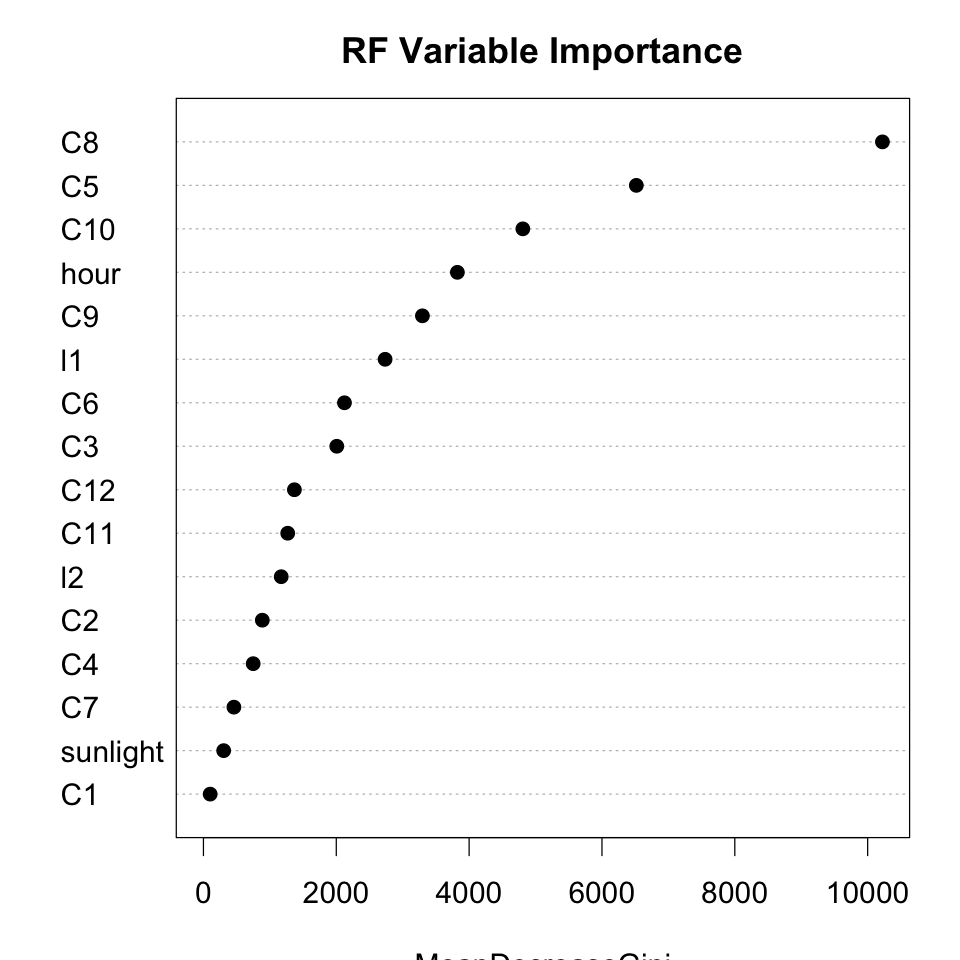

In [54]:
set.seed(123)
model=randomForest(label~.,trainset,mtry=3,ntree=750)
#evaluate RF trainset
evalmetrics(model,trainset)
#evaluate RF trainset
evalmetrics(model,testset)
#variable importance
varImpPlot(model,color="black",pch=19,cex=1.5,main="RF Variable Importance")

RandomForest of Daylight Hours

In [55]:
dataa=data[data$sunlight==1,]
cols=c("label",numericcols,catcols,"hour")
#downsample data to get class balance
set.seed(123)
data2=dataa[dataa$label==1,cols]
data0=dataa[dataa$label==0,cols]
sampled=sample(1:nrow(data0),size=nrow(data2))
data2=rbind(data2,data0[sampled,])
summary(data2)

 label           l1                 l2                   C1        
 0:54004   Min.   :    0.00   Min.   : 0.0000   3480220152:    47  
 1:54004   1st Qu.:    0.00   1st Qu.: 0.0000   4091568405:    44  
           Median :    1.00   Median : 0.0000   4013070138:    42  
           Mean   :   54.79   Mean   : 0.1252   609480216 :    36  
           3rd Qu.:    7.00   3rd Qu.: 0.0000   3018961855:    30  
           Max.   :33906.00   Max.   :92.0000   992635198 :    29  
                                                (Other)   :107780  
          C2               C3              C4               C5       
 2879782277:  1191   2252   : 4399   26981  :  1191   30     :17070  
 3775616631:   867   2081   : 2642   14838  :   867   83     :10800  
 2277192293:   751   6216   : 2058   21050  :   751   1      :10153  
 3126403322:   619   3774   : 1356   25359  :   619   10     : 8563  
 1161865110:   615   5704   : 1220   29016  :   615   88     : 8074  
 3262164123:   508   3550   :  928  

In [56]:
#rf doesn't like when there's more than 53 categories within a predictor
for(i in c(catcols)){
  freqs=as.numeric(names(sort(table(data2[,i]),decreasing=T)[1:min(52,length(unique(data2[,i])))]))
  v=data2[,i]
  vv=sapply(v,function(ii) if(ii %in% freqs) ii else -1)
  data2[,i]=as.factor(vv)
}

In [57]:
#train/test sets
set.seed(123)
sampled <- sample(1:nrow(data2),size=.7*nrow(data2))
trainset=data2[sampled,]
testset=data2[-sampled,]

[1] 0.9165664 0.9017289 0.9314687

[1] 0.8011295 0.8584279 0.7444117

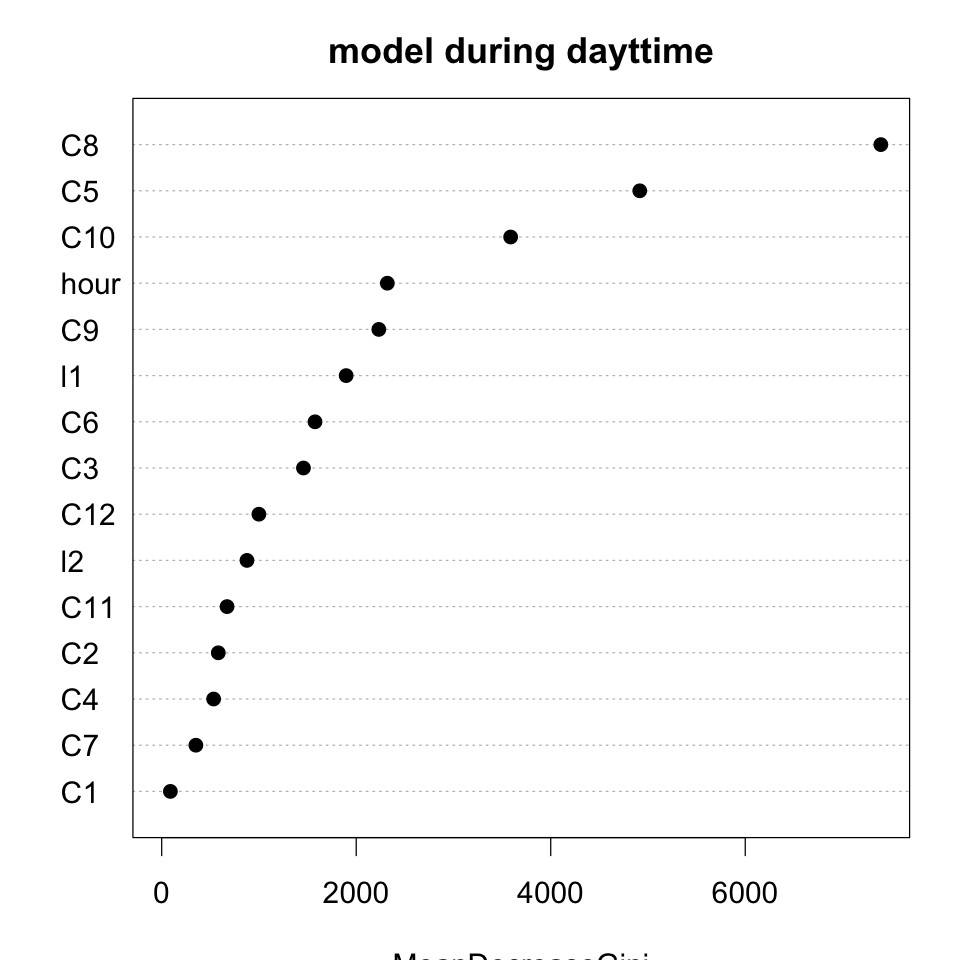

In [58]:
model=randomForest(label~.,trainset)
#evaluate RF trainset
evalmetrics(model,trainset)
#evaluate RF trainset
evalmetrics(model,testset)
#variable importance
varImpPlot(model,color="black",pch=19,cex=1.5,main="model during dayttime")

RandomForest of Nighttime Hours

In [59]:
dataa=data[data$sunlight==0,]
cols=c("label",numericcols,catcols,"hour")
#downsample data to get class balance
set.seed(123)
data2=dataa[dataa$label==1,cols]
data0=dataa[dataa$label==0,cols]
sampled=sample(1:nrow(data0),size=nrow(data2))
data2=rbind(data2,data0[sampled,])
summary(data2)

 label           l1                 l2                   C1       
 0:22298   Min.   :    0.00   Min.   : 0.0000   4013070138:   52  
 1:22298   1st Qu.:    0.00   1st Qu.: 0.0000   2532552348:   33  
           Median :    1.00   Median : 0.0000   1480636129:   29  
           Mean   :   60.07   Mean   : 0.1152   3018961855:   19  
           3rd Qu.:    7.00   3rd Qu.: 0.0000   3428596202:   19  
           Max.   :25894.00   Max.   :75.0000   2075671839:   18  
                                                (Other)   :44426  
          C2              C3              C4              C5       
 2879782277:  356   2252   : 1978   26981  :  356   30     : 5421  
 3775616631:  349   2081   : 1196   14838  :  349   1      : 5315  
 2277192293:  339   5704   :  828   27694  :  340   83     : 3983  
 3126403322:  290   6216   :  705   21050  :  339   10     : 3330  
 1161865110:  285   4454   :  558   25359  :  290   88     : 2855  
 4110536592:  281   4363   :  532   29016  :  285   6   

In [60]:
#rf doesn't like when there's more than 53 categories within a predictor
for(i in c(catcols)){
  freqs=as.numeric(names(sort(table(data2[,i]),decreasing=T)[1:min(52,length(unique(data2[,i])))]))
  v=data2[,i]
  vv=sapply(v,function(ii) if(ii %in% freqs) ii else -1)
  data2[,i]=as.factor(vv)
}

In [61]:
#train/test sets
set.seed(123)
sampled <- sample(1:nrow(data2),size=.7*nrow(data2))
trainset=data2[sampled,]
testset=data2[-sampled,]

[1] 0.9497389 0.9383667 0.9610639

[1] 0.7965468 0.8873847 0.7048220

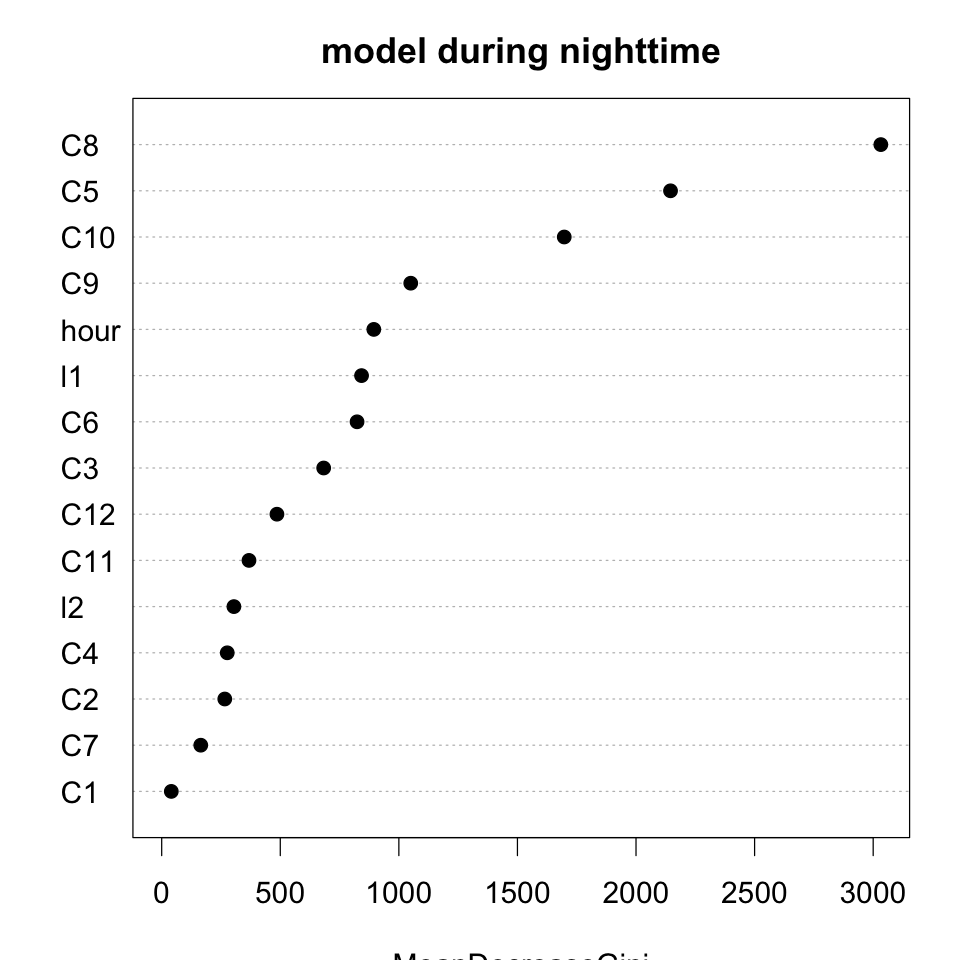

In [62]:
model=randomForest(label~.,trainset)
#evaluate RF trainset
evalmetrics(model,trainset)
#evaluate RF trainset
evalmetrics(model,testset)
#variable importance
varImpPlot(model,color="black",pch=19,cex=1.5,main="model during nighttime")

### Time Series

<a class="anchor" id="timeseries"></a>

ARIMA Model

setting up

In [63]:
data <- read.csv('../Data/train_sampled2.csv', sep=';')

data$datetime=anytime(data$timestamp)
data$label<-as.factor(data$label)

train <- data[1:808332,]

test <- data[808333:nrow(data),]

sum(is.na(data$datetime))

[1] 0

Training downsample

In [64]:
traindownsample <- downSample(x = train[,-1],
                              y = train$label)

Timeseries setup

ts on all data

A Time Series:
[1] 1 1 1 1 1 1
attr(,"levels")
[1] "0" "1"

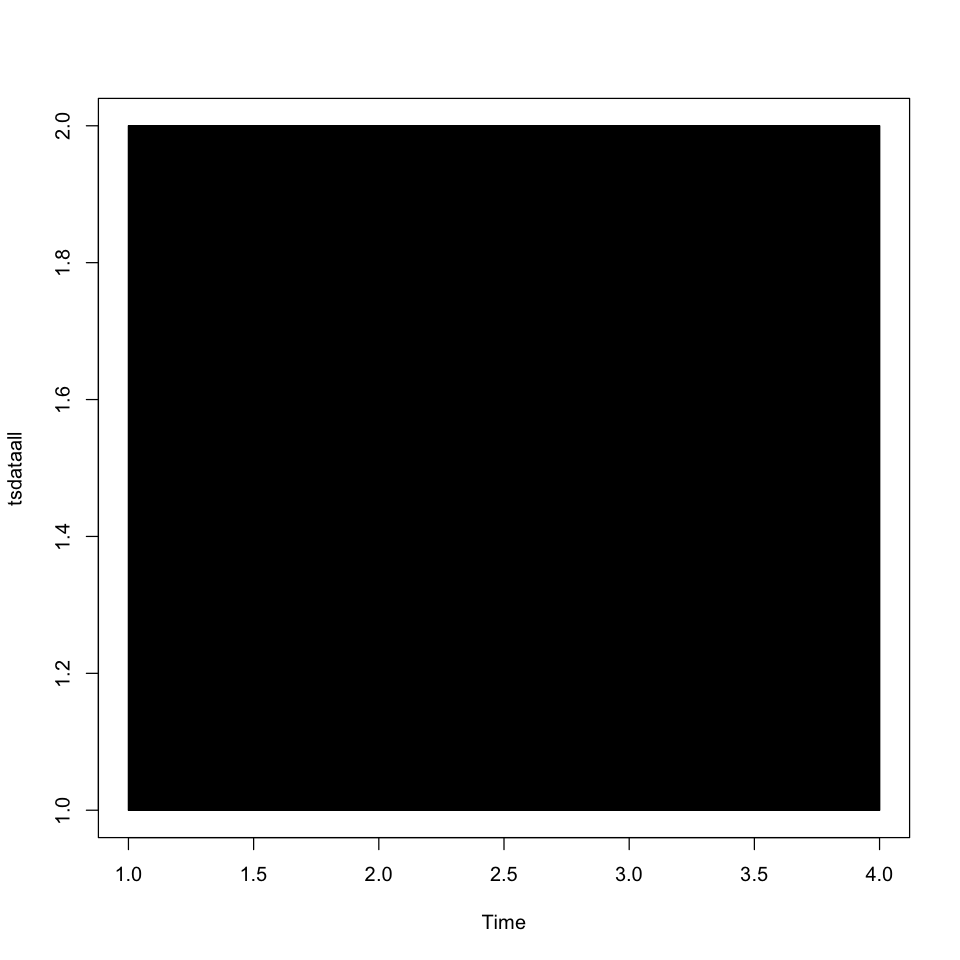

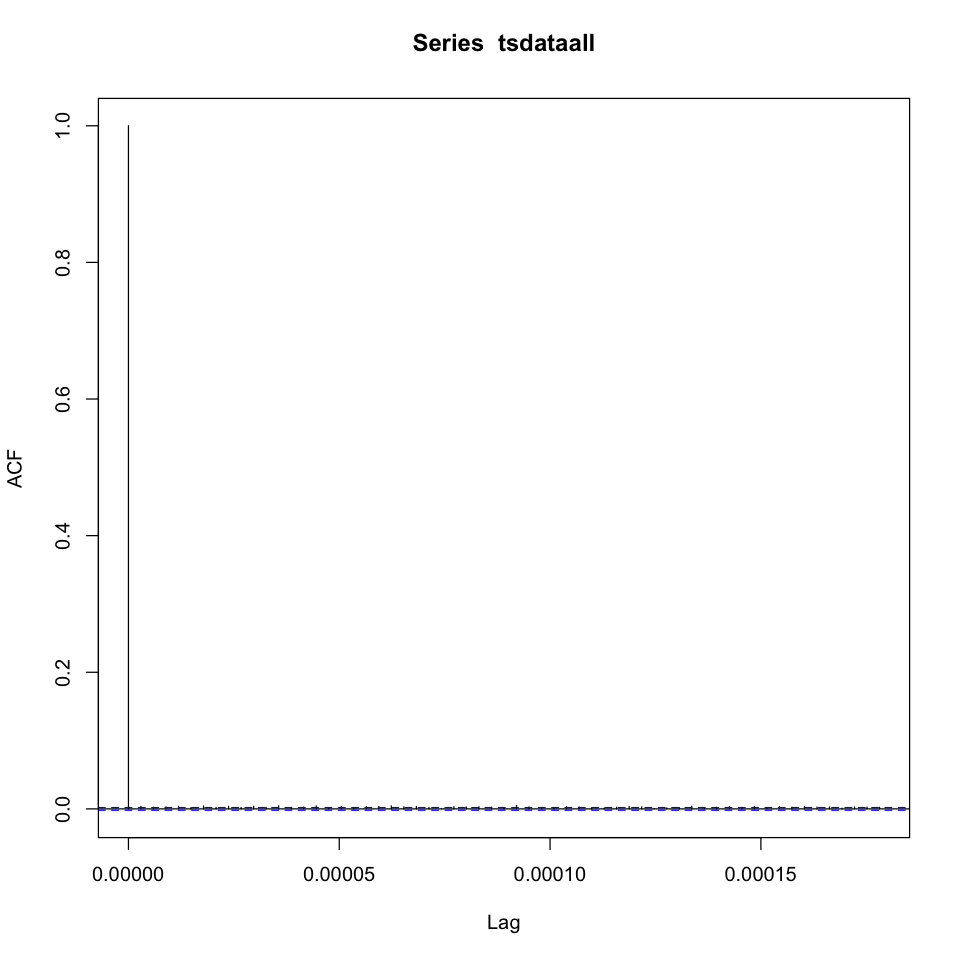

Warning message in adf.test(tsdataall):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  tsdataall
Dickey-Fuller = -90.694, Lag order = 100, p-value = 0.01
alternative hypothesis: stationary


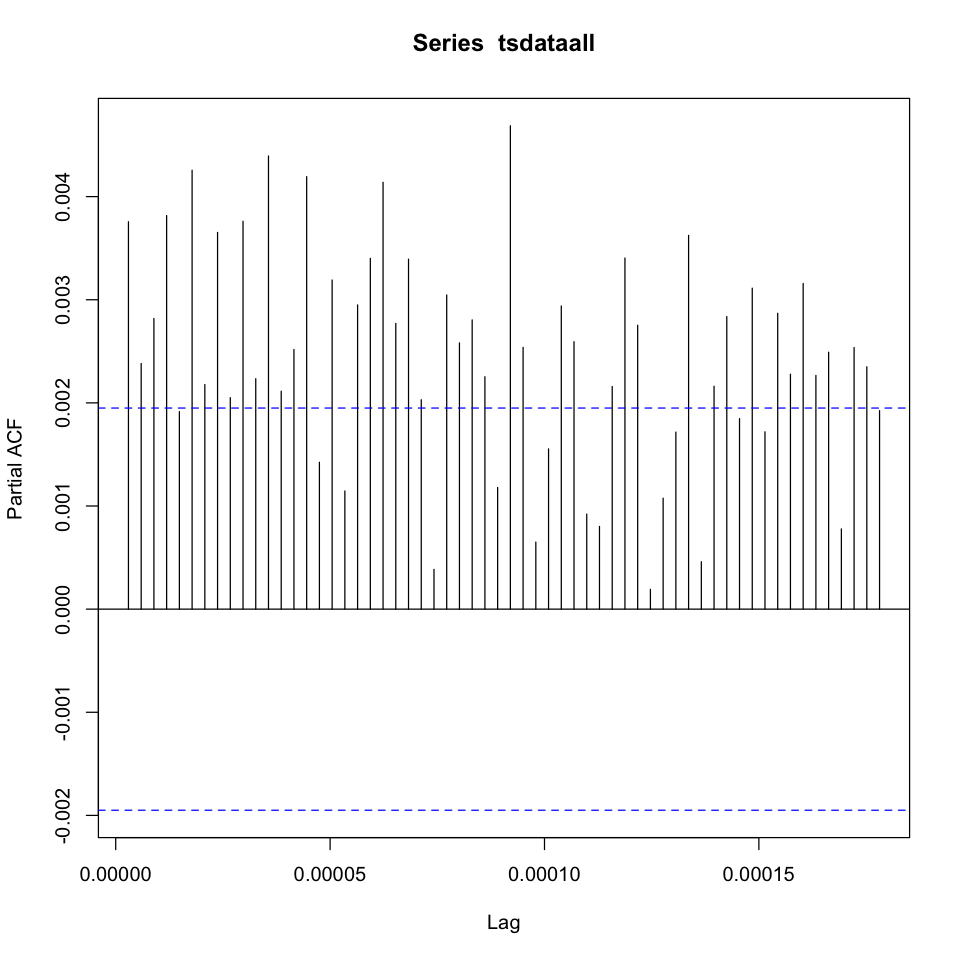

In [65]:
tsdataall<-ts(data$label, frequency=(nrow(data)/3))
head(tsdataall)
ddataall <- decompose(tsdataall)
plot(tsdataall)
acf(tsdataall)
pacf(tsdataall)
adf.test(tsdataall)

ts on train data

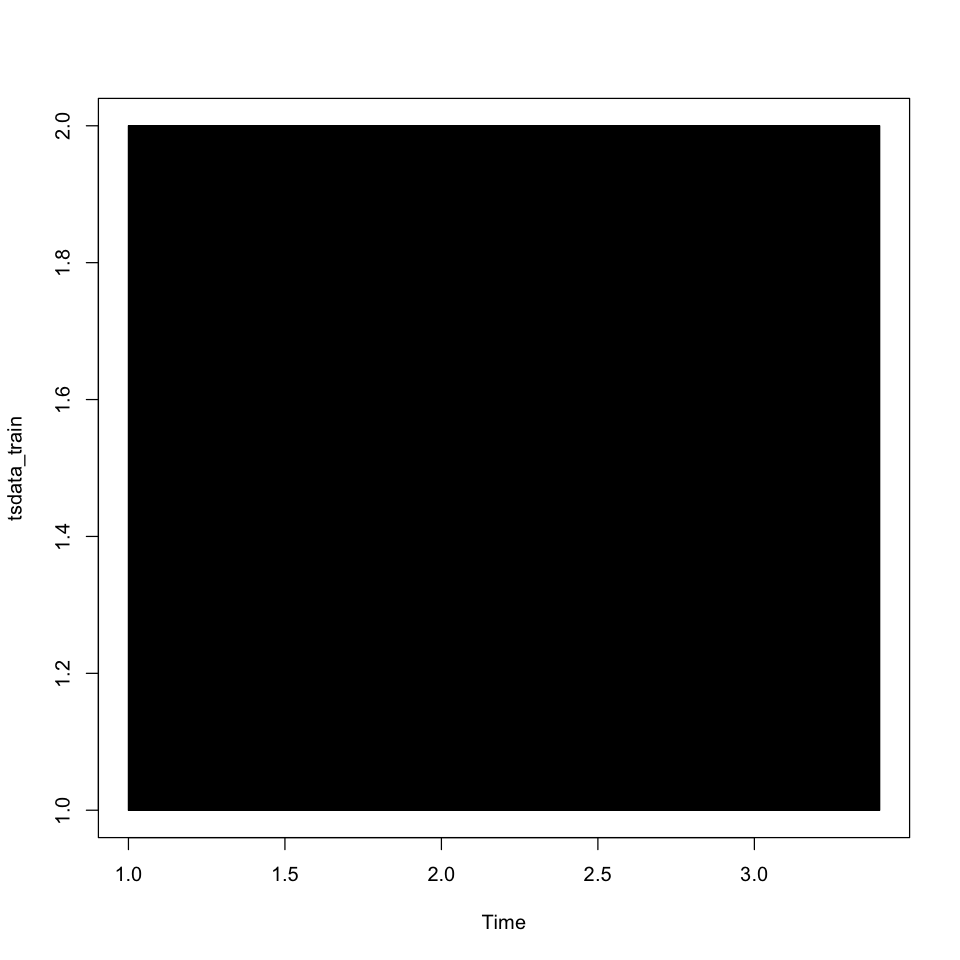

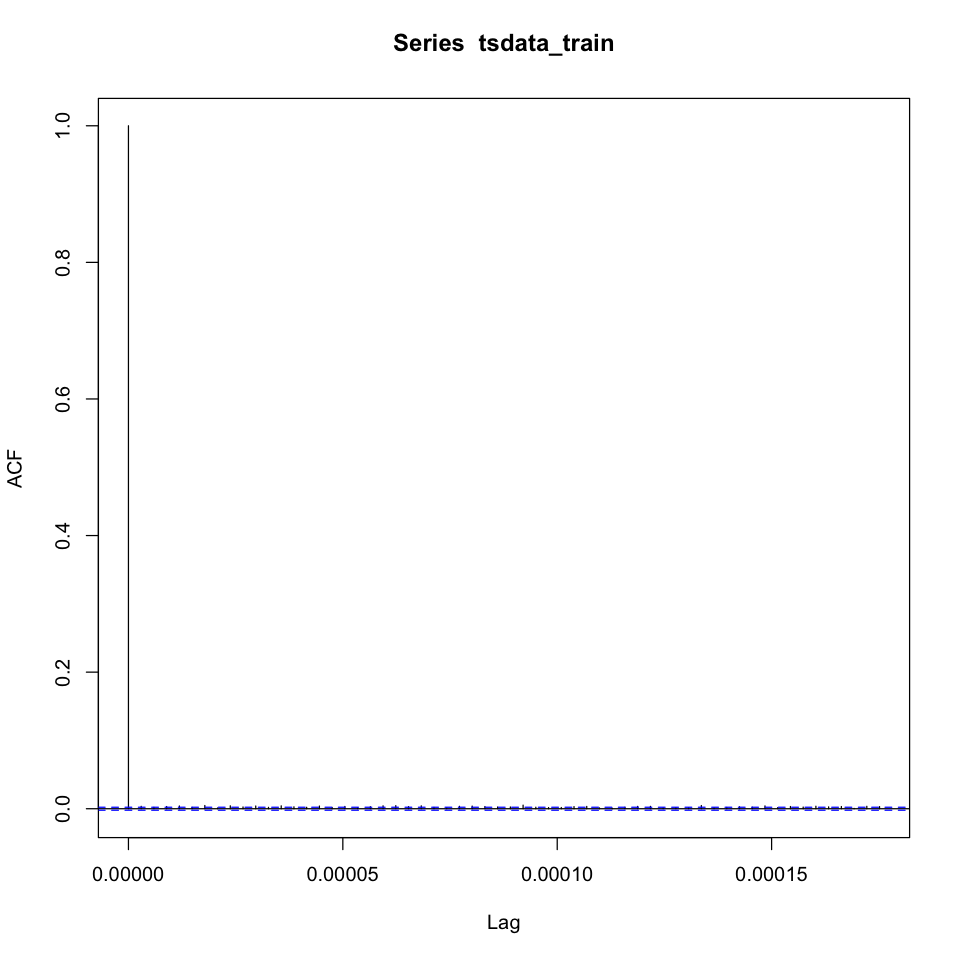

Warning message in adf.test(tsdata_train):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  tsdata_train
Dickey-Fuller = -84.215, Lag order = 93, p-value = 0.01
alternative hypothesis: stationary


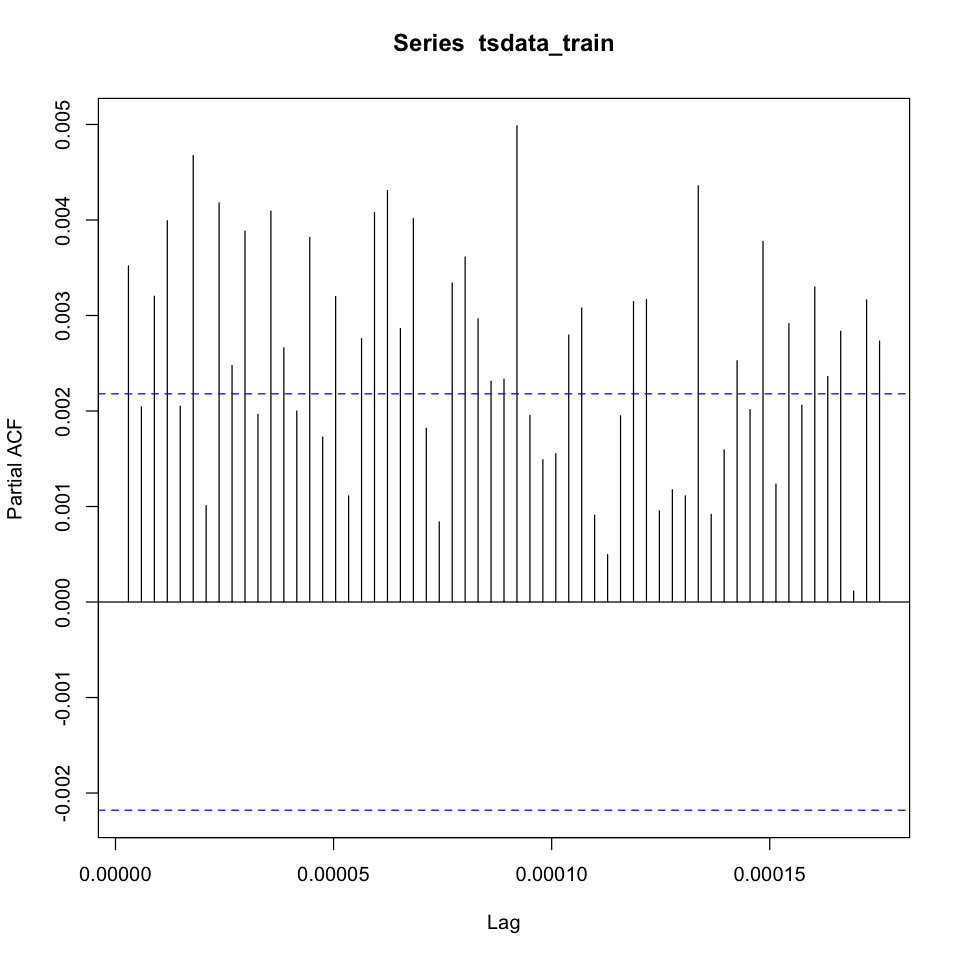

In [66]:

tsdata_train<-ts(train$label, frequency=(nrow(data)/3))
ddatatrain <- decompose(tsdata_train)
plot(tsdata_train)
acf(tsdata_train)
pacf(tsdata_train)
adf.test(tsdata_train)

ts on test data

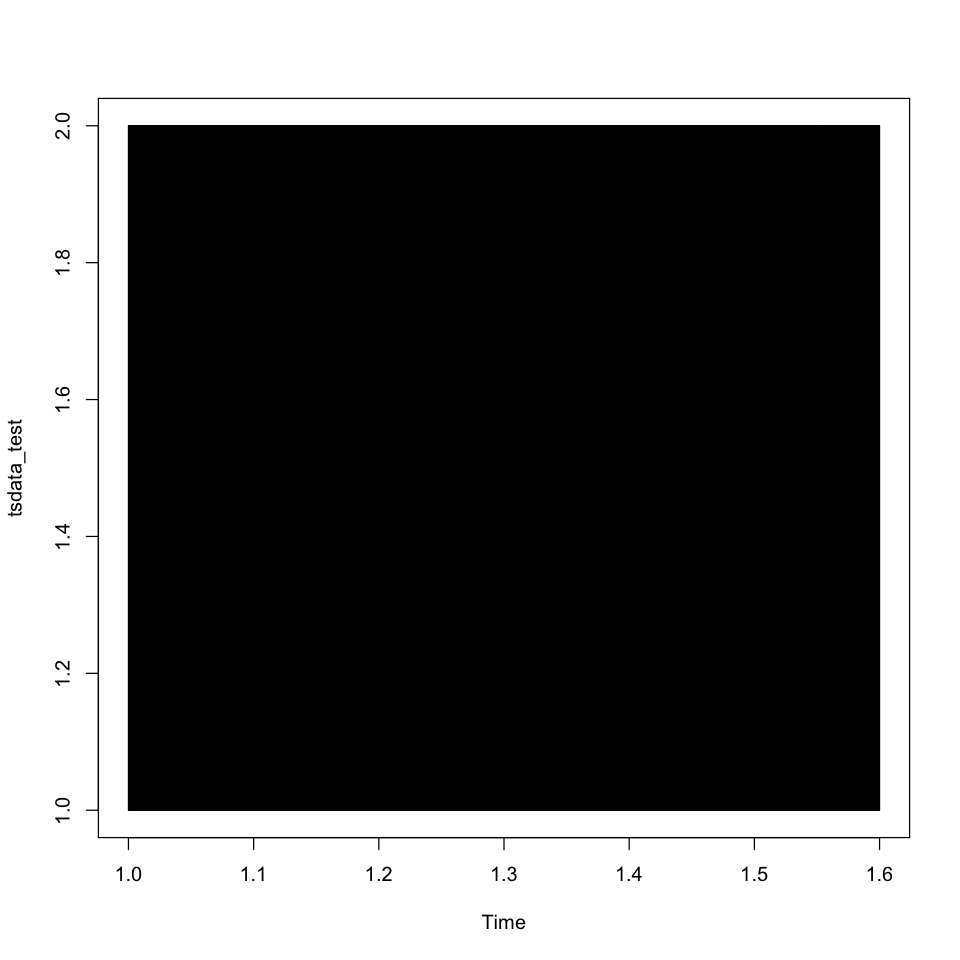

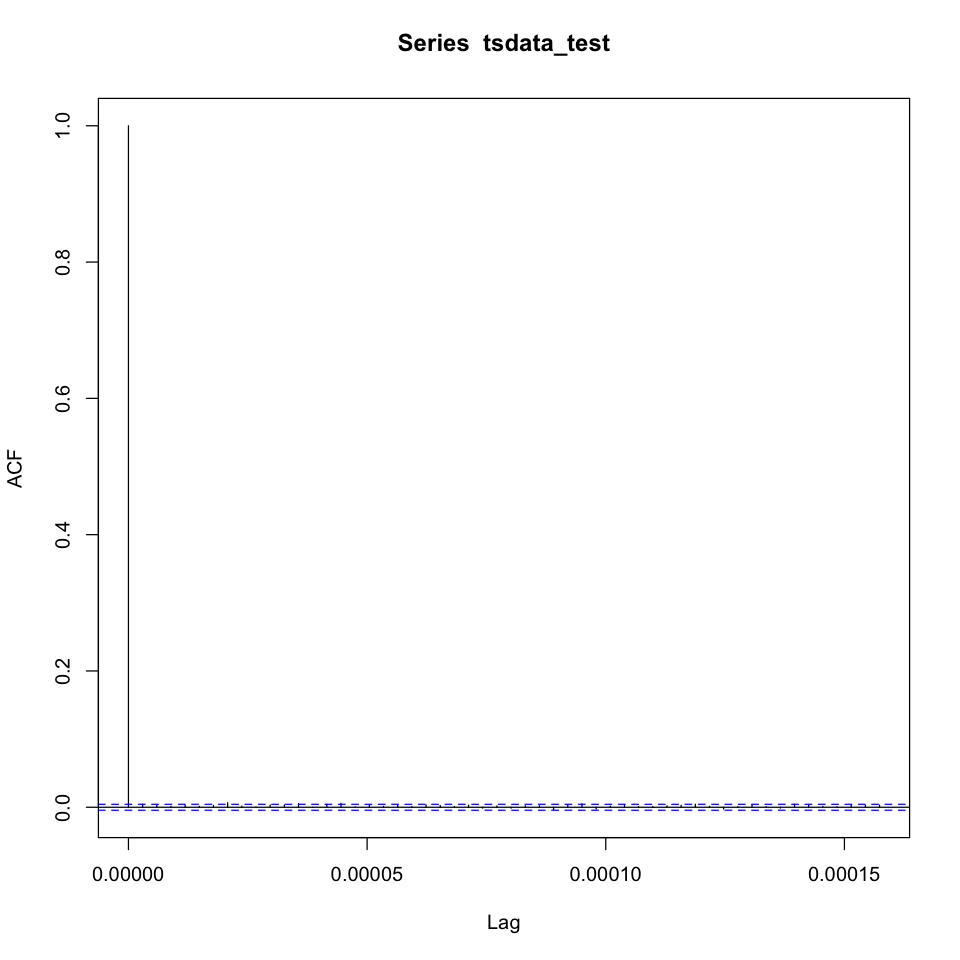

Warning message in adf.test(tsdata_test):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  tsdata_test
Dickey-Fuller = -57.318, Lag order = 58, p-value = 0.01
alternative hypothesis: stationary


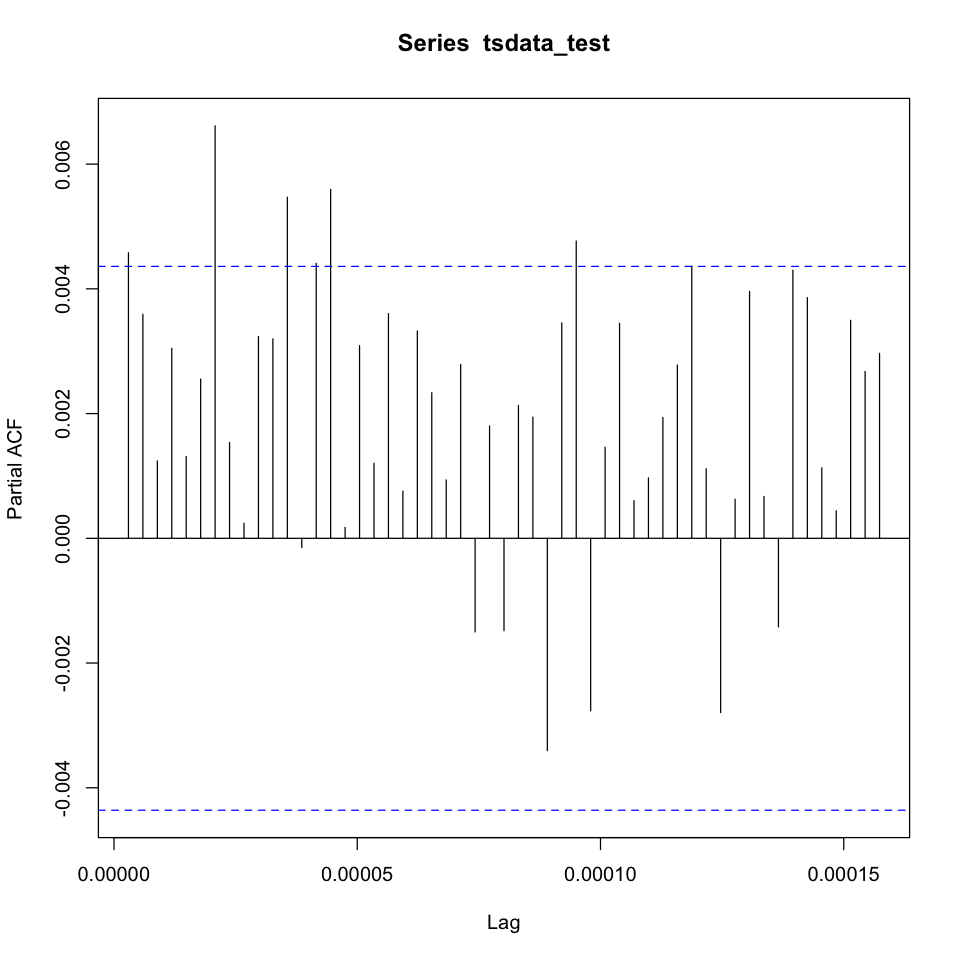

In [67]:

tsdata_test<-ts(test$label, frequency=(nrow(data)/3))
plot(tsdata_test)
acf(tsdata_test)
pacf(tsdata_test)
adf.test(tsdata_test)

ts on downsample

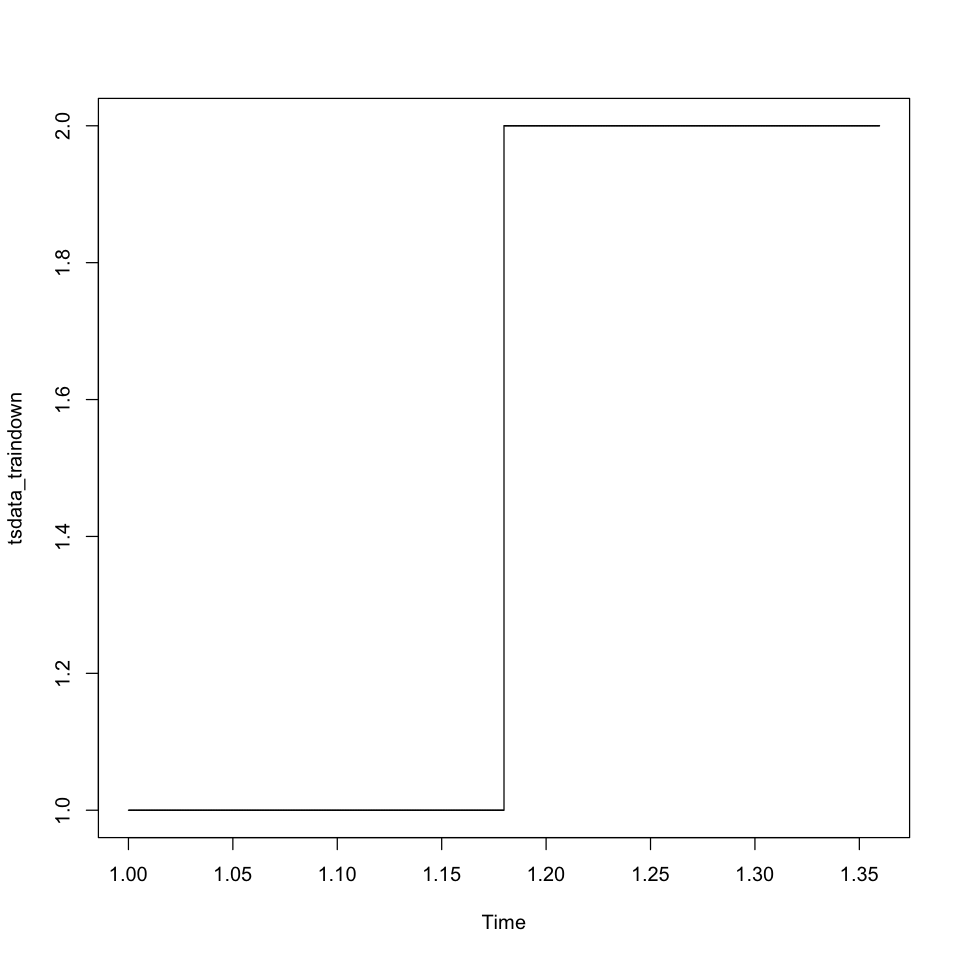

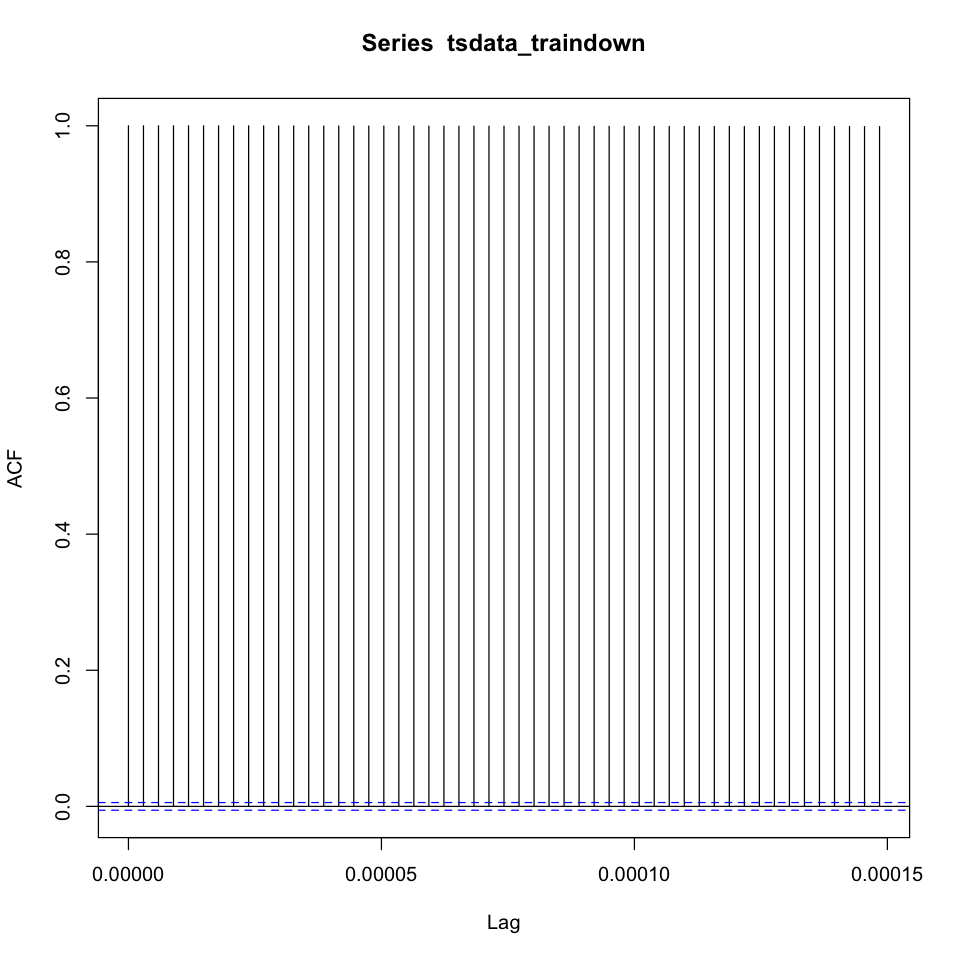


	Augmented Dickey-Fuller Test

data:  tsdata_traindown
Dickey-Fuller = -2, Lag order = 49, p-value = 0.5791
alternative hypothesis: stationary


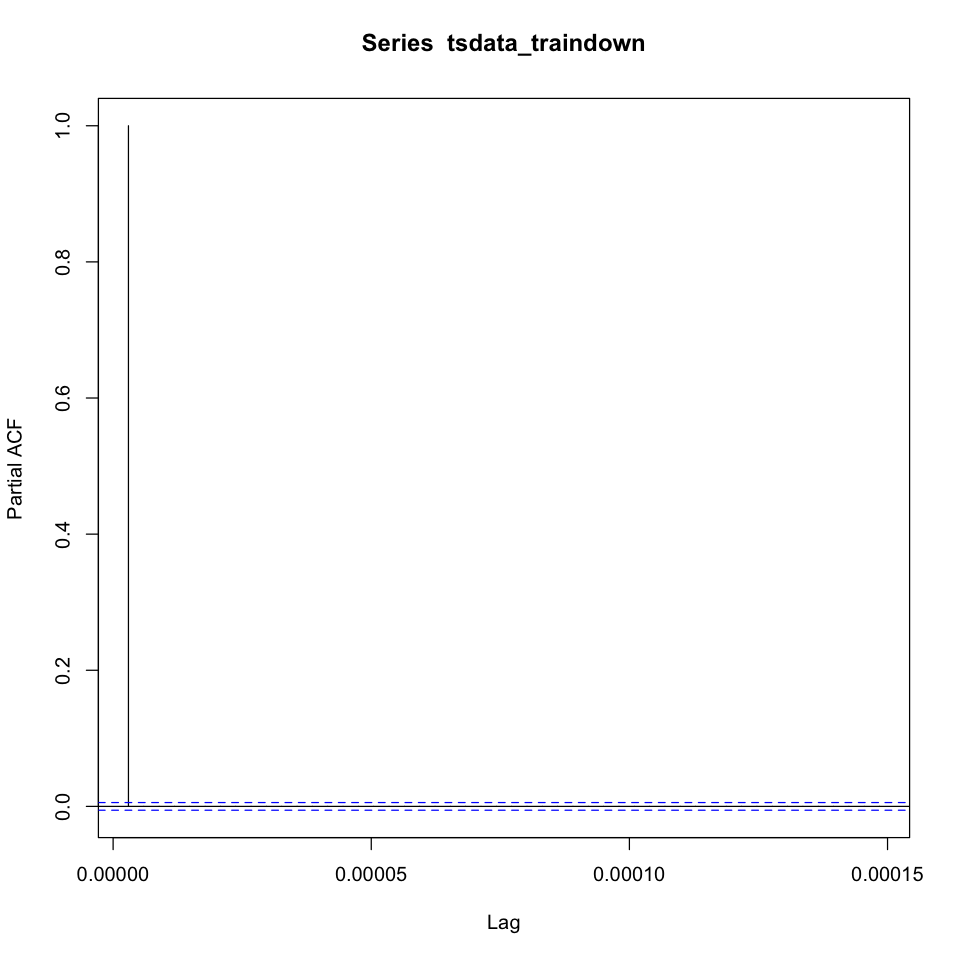

In [68]:

tsdata_traindown<-ts(traindownsample$label, frequency=(nrow(data)/3))
plot(tsdata_traindown)
acf(tsdata_traindown)
pacf(tsdata_traindown)
adf.test(tsdata_traindown)

ARIMA Train Model


	Ljung-Box test

data:  Residuals from ARIMA(5,1,0)
Q* = 220162, df = 161661, p-value < 2.2e-16

Model df: 5.   Total lags used: 161666



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,2.092866e-07,0.2838893,0.1381822,-3.45454,10.36366,1.000932,-0.02368376



	Box-Ljung test

data:  forecastarima$residuals
X-squared = 25089, df = 5, p-value < 2.2e-16


A Time Series:
    [1] 0.9990000 0.9999993 0.9999996 0.9999997 0.9999998 0.9999998 1.0000000
    [8] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [15] 1.1669703 1.1652616 1.1667486 1.1675546 1.1652935 1.1681714 1.0000000
   [22] 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486 1.1675546 1.1652935
   [29] 1.1681714 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [36] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616
   [43] 1.1667486 1.1675546 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000
   [50] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [57] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [64] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [71] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [78] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [85] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [92] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
   [99] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [106] 1.0000000 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616 1.3337189
  [113] 1.3328163 1.4990123 1.5009877 1.3320421 1.3357260 1.1652935 1.1681714
  [120] 1.1669703 1.1652616 1.1667486 1.1675546 1.1652935 1.1681714 1.0000000
  [127] 1.0000000 1.1669703 1.1652616 1.1667486 1.1675546 1.3322638 1.3334330
  [134] 1.1667486 1.1675546 1.1652935 1.1681714 1.1669703 1.1652616 1.3337189
  [141] 1.3328163 1.3320421 1.3357260 1.1652935 1.1681714 1.0000000 1.0000000
  [148] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [155] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [162] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616
  [169] 1.1667486 1.1675546 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000
  [176] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [183] 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486 1.1675546
  [190] 1.1652935 1.1681714 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486
  [197] 1.1675546 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000 1.0000000
  [204] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616
  [211] 1.1667486 1.1675546 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000
  [218] 1.0000000 1.1669703 1.1652616 1.1667486 1.1675546 1.1652935 1.1681714
  [225] 1.1669703 1.1652616 1.1667486 1.1675546 1.1652935 1.1681714 1.0000000
  [232] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [239] 1.1669703 1.1652616 1.1667486 1.1675546 1.1652935 1.1681714 1.0000000
  [246] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [253] 1.0000000 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486
  [260] 1.1675546 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000 1.0000000
  [267] 1.0000000 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486
  [274] 1.1675546 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000 1.0000000
  [281] 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486 1.1675546
  [288] 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [295] 1.0000000 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486
  [302] 1.1675546 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000 1.0000000
  [309] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [316] 1.0000000 1.0000000 1.0000000 1.1669703 1.1652616 1.1667486 1.1675546
  [323] 1.1652935 1.1681714 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [330] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [337] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [344] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [351] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
  [358]

Warning message in confusionMatrix.default(as.factor(predicted$modelpreds), predicted$`train$label`, :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0      0      0
         1 747761  60571
                                          
               Accuracy : 0.0749          
                 95% CI : (0.0744, 0.0755)
    No Information Rate : 0.9251          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.00000         
            Specificity : 0.00000         
         Pos Pred Value : 0.07493         
         Neg Pred Value :     NaN         
             Prevalence : 0.07493         
         Detection Rate : 0.07493         
   Detection Prevalence : 1.00000         
      Balanced Accuracy : 0.50000         
                                          
       'Positive' Class : 1               
            

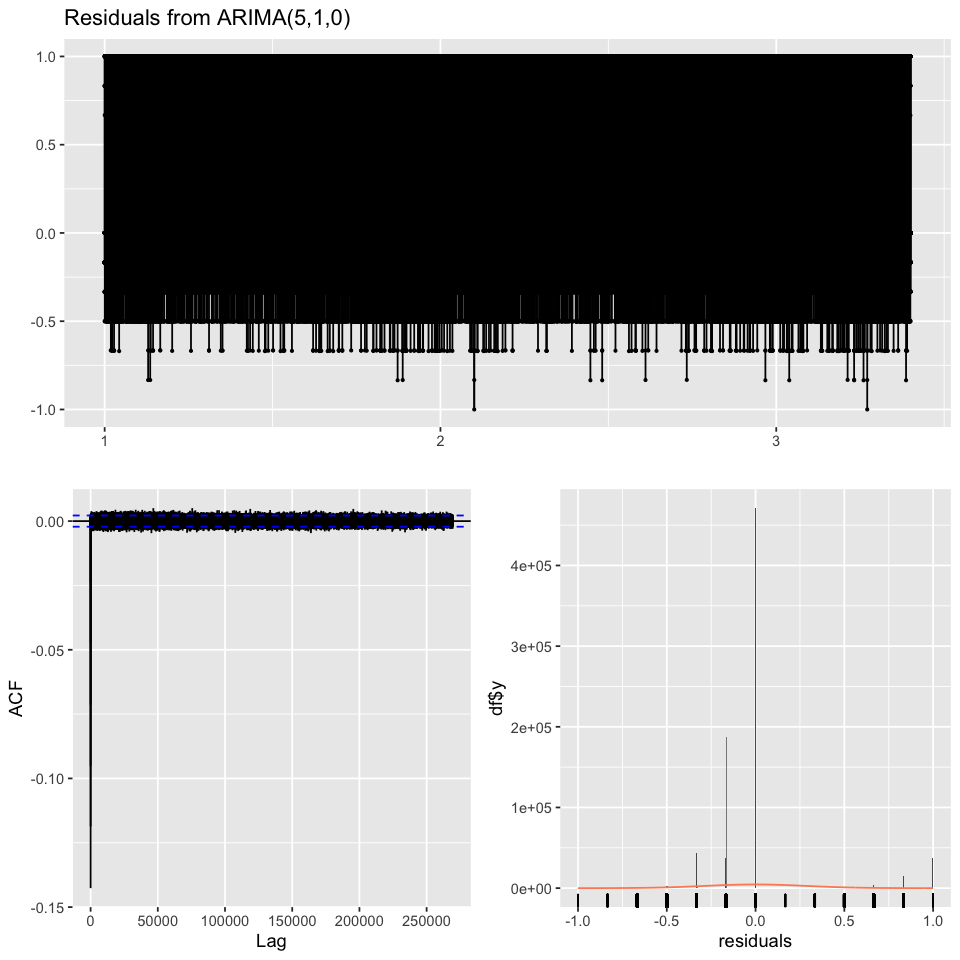

In [69]:
modelarima <- auto.arima(tsdata_train,
                        stepwise = T,
                        approximation = F,ic="aic")
checkresiduals(modelarima)

a_train<-accuracy(modelarima)
a_train

forecastarima<-forecast(modelarima,level=c(95))
Box.test(forecastarima$residuals, type="Ljung-Box", lag=5)
modelarima$fitted
cutoff = 0.5
preds <- as.integer(forecastarima$fitted >= cutoff)

predicted <- cbind(data.frame(modelpreds=preds), train$label)
arimacm <- confusionMatrix(as.factor(predicted$modelpreds),predicted$`train$label`,positive='1')
arimacm

ARIMA Downsample Train Model

In [70]:
modelarimadown <- auto.arima(tsdata_traindown,
                         stepwise = T,
                         approximation = F,ic="aic")
modelarimadown

a_traindown<-accuracy(modelarimadown)
a_traindown

forecastarimadown<-forecast(modelarimadown,level=c(95))
Box.test(forecastarimadown$residuals, type="Ljung-Box")

predsdown <- as.integer(forecastarimadown$fitted >= cutoff)

predicteddown <- cbind(data.frame(modelpreds=predsdown), traindownsample$label)

arimacmdown <- confusionMatrix(as.factor(predicteddown$modelpreds),predicteddown$'traindownsample$label',
                               positive='1')
arimacmdown

Series: tsdata_traindown 
ARIMA(0,1,0) 

sigma^2 = 8.255e-06:  log likelihood = 537068.5
AIC=-1074135   AICc=-1074135   BIC=-1074125

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,8.26303e-06,0.002873114,8.26303e-06,0.0004135642,0.0004135642,NaN,-8.263159e-06



	Box-Ljung test

data:  forecastarimadown$residuals
X-squared = 8.2718e-06, df = 1, p-value = 0.9977


Warning message in confusionMatrix.default(as.factor(predicteddown$modelpreds), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0     0     0
         1 60571 60571
                                          
               Accuracy : 0.5             
                 95% CI : (0.4972, 0.5028)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.5011          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0             
            Specificity : 0.0             
         Pos Pred Value : 0.5             
         Neg Pred Value : NaN             
             Prevalence : 0.5             
         Detection Rate : 0.5             
   Detection Prevalence : 1.0             
      Balanced Accuracy : 0.5             
                                          
       'Positive' Class : 1               
                  

ARIMA Test Model

In [71]:
ARIMAtest <- Arima(tsdata_test,model=modelarima)
accuracy(ARIMAtest)

forecastarimatest<-forecast(ARIMAtest, level=c(95))
Box.test(forecastarimatest$residuals, type="Ljung-Box")

predstest <- as.integer(forecastarimatest$fitted >= cutoff)

predictedtest<- cbind(data.frame(modelpreds=predstest), test$label)

arimacmtest <- confusionMatrix(as.factor(predictedtest$modelpreds),predictedtest$'test$label',positive='1')
arimacmtest

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,2.464668e-06,0.2890478,0.1431729,-3.579138,10.73791,NaN,-0.02271678



	Box-Ljung test

data:  forecastarimatest$residuals
X-squared = 104.29, df = 1, p-value < 2.2e-16


Warning message in confusionMatrix.default(as.factor(predictedtest$modelpreds), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0      0      0
         1 186351  15731
                                         
               Accuracy : 0.0778         
                 95% CI : (0.0767, 0.079)
    No Information Rate : 0.9222         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0              
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 1.00000        
            Specificity : 0.00000        
         Pos Pred Value : 0.07784        
         Neg Pred Value :     NaN        
             Prevalence : 0.07784        
         Detection Rate : 0.07784        
   Detection Prevalence : 1.00000        
      Balanced Accuracy : 0.50000        
                                         
       'Positive' Class : 1              
                                

### Summary of Results

<a class="anchor" id="resultssummary"></a>

## Random Forest Performs the Best
The random forest model produced the best performance, with an overall accuracy on the test set of 80.2%. Sensitivity came in at 87.5% and Specificity was 73.0%.

## Logistic Regression Provides Insights into Variable Importance
Various runs of Logistic Regression on this data produced a model with a maximum accuracy of 73.3% on the test set, with Sensitivity of 75.0% and Specificity of 73.3%. Categorical features C7 and C12, along with counters l1 and l2 possessed the largest coefficients and thus presented with the largest probably effect on the predicted outcome of the models.

## Time Series Analysis Fails to Net Meaningful Results
In the time we had we were unable to produce any meaningful time series insights leading us to believe that seasonality is nonexistent and or extremely hard to detect in this data. Given more time we would explore this area further.
